In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from ete3 import Tree
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import seaborn as sns
import matplotlib.pyplot as plt
import os

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
do_weighted = False

relevant_features = ["partner.diversity", # shanon diversity
                     "d", # speciality index d',
                     "normalised.degree",
                     "weighted.betweenness", # centrality,
                     "weighted.closeness",
                     "hubbiness_score"]  # generality
relevant_features += [f"standardized_{f}" for f in relevant_features]

allmb_tree_path = "../../../data/trees/families_mrca_based_tree.nwk"
networks_dir = "../../../data/networks/all/"
species_features_paths = {"binary": "../../../data/features/plant/binary/features_with_classification.csv",
                          "binarized_weighted": "../../../data/features/plant/binarized_weighted/features_with_classification.csv",
                          "weighted": "../../../data/features/plant/weighted/features_with_classification.csv"}

classification_path = "../../../data/ploidy_classification/plant_classification.csv"
ploidb_path = "../../../data/ploidy_classification/ploidb_by_genus_without_missing.csv"

taxonomic_data_path = "../../../data/features/taxonomic_features/net_to_pollinators_taxonomic_classification.csv"
networks_metadata_path = "../../../data/networks/networks_metadata.csv"
plant_metadata_path = "../../../data/plant_traits_db.csv"
ccdb_path = "/groups/itay_mayrose/halabikeren/PloiDB/ccdb_all_data_171122.csv"
species_mating_system_data_path = "../../../data/metadata/species_level/mating_system_grossenbacher_2017.xlsx"
species_metadata_path_1 = "../../../data/metadata/species_level/plants_metadata_rice_2019.xlsx"
species_metadata_path_2 = "../../../data/metadata/species_level/LifeForm_Database.xlsx"
species_metadata_path_3 = "../../../data/metadata/species_level/PPN_spp-floral-traits_DATA-CHECK_8-4-23_NSS.xlsx"
lf_mapping_path= "../../../data/metadata/species_level/LifeFormMapping.xlsx"
lf_manual_classification_path = "../../../data/metadata/species_level/lf_manual_classification.csv"

processed_data_path = f"../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks.csv"
pre_processed_tree_path = f"../../../data/statistical_analysis/species_level/unique_species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"
processed_tree_path = f"../../../data/statistical_analysis/species_level/species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"
species_list_path = f"../../../data/statistical_analysis/species_level/species_list_{'un' if not do_weighted else ''}weighted_analysis.csv"

# process data

In [54]:
allmb_tree = Tree(allmb_tree_path)
for leaf in allmb_tree.get_leaves():
    leaf.name = leaf.name.lower().replace("_", " ")

In [55]:
relevant_columns = ["Plant", "network_id"] + relevant_features
weighted_data = pd.read_csv(species_features_paths["weighted"])
weighted_data = weighted_data.rename(columns={c: c.replace("_y","") for c in weighted_data.columns if c.endswith("_y")})
weighted_data = weighted_data[relevant_columns]
weighted_data["network_type"] = "weighted"

binarized_weighted_data = pd.read_csv(species_features_paths["binarized_weighted"])
binarized_weighted_data = binarized_weighted_data.rename(columns={c: c.replace("_y","") for c in binarized_weighted_data.columns if c.endswith("_y")})
binarized_weighted_data = binarized_weighted_data[relevant_columns]
binarized_weighted_data["network_type"] = "binarized_weighted"

binary_data = pd.read_csv(species_features_paths["binary"])
binary_data = binary_data.rename(columns={c: c.replace("_y","") for c in binary_data.columns if c.endswith("_y")})
binary_data = binary_data[relevant_columns]
binary_data["network_type"] = "binary"  

features = pd.concat([weighted_data,binarized_weighted_data,binary_data])
features["original_name"] = features.Plant.str.lower()

In [56]:
classification = pd.read_csv(classification_path).rename(columns={"polyploid_age": "ploidy_age"})

In [59]:
features_with_classification = features.merge(classification[["original_name", "resolved_name", "is_polyploid", "ploidy_age"]], on="original_name", how="left")
features_with_classification.set_index("original_name", inplace=True)
features_with_classification["is_polyploid"].fillna(classification.set_index("original_name")["is_polyploid_by_original"].to_dict(), inplace=True)
features_with_classification["ploidy_age"].fillna(classification.set_index("original_name")["polyploid_age_by_original"].to_dict(), inplace=True)
features_with_classification.reset_index(inplace=True)

In [68]:
df = features_with_classification.query("network_type != 'binarized_weighted'")
(df[['network_id', 'network_type']].drop_duplicates().shape[0])

891

In [81]:
len(df.loc[(df.resolved_name.notna()) & (df.is_polyploid.notna())].Plant.dropna().unique())

1714

In [77]:
len(df.Plant.unique())-len(df.loc[df.is_polyploid.isna()].Plant.unique())

1776

In [176]:
features_with_classification.groupby("is_polyploid", dropna=False)["original_name"].count() / features_with_classification.shape[0]*100

is_polyploid
0.0    26.025954
1.0    26.304307
NaN    47.669739
Name: original_name, dtype: float64

In [177]:
clean_features_with_classification = features_with_classification.dropna(subset=relevant_features+["is_polyploid"], how="any", axis=0)

In [178]:
clean_features_with_classification.groupby("is_polyploid", dropna=False)["original_name"].count() / clean_features_with_classification.shape[0]*100

is_polyploid
0.0    49.818676
1.0    50.181324
Name: original_name, dtype: float64

In [101]:
print(f"# species from networks = {len(clean_features_with_classification.original_name.unique()):,}")
print(f"# species in tree = {len(allmb_tree.get_leaf_names()):,}")

# species from networks = 1,746
# species in tree = 67,712


In [102]:
if do_weighted:
    clean_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.network_type == "weighted"]
else:
    clean_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.network_type != "weighted"]

In [103]:
tree_names = set(allmb_tree.get_leaf_names())
final_features_with_classification = clean_features_with_classification.copy()
final_features_with_classification["mapped_name"] = final_features_with_classification.apply(lambda record: record.original_name if record.original_name in tree_names else record.resolved_name, axis=1)


limited_final_features_with_classification = final_features_with_classification.loc[final_features_with_classification.original_name.isin(tree_names) |
                                                                                    final_features_with_classification.resolved_name.isin(tree_names)]

print(f"# species from networks for analysis = {len(limited_final_features_with_classification.mapped_name.unique()):,}")

# species from networks for analysis = 1,454


In [104]:
pruned_allmb_tree = allmb_tree.copy()
pruned_allmb_tree.prune(limited_final_features_with_classification.mapped_name.unique().tolist(), preserve_branch_length=True)
print(f"# species in tree = {len(pruned_allmb_tree.get_leaf_names()):,}")

# species in tree = 1,454


In [105]:
final_features_with_classification["mapped_name"] = final_features_with_classification["mapped_name"].str.replace(" ", "_")
final_features_with_classification["sample_id"] = final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_classification["network_id"].astype("str")
final_features_with_classification.sample_id = final_features_with_classification.sample_id.str.replace(" ", "_")

limited_final_features_with_classification["mapped_name"] = limited_final_features_with_classification["mapped_name"].str.replace(" ", "_")
limited_final_features_with_classification["sample_id"] = limited_final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_classification["network_id"].astype("str")
limited_final_features_with_classification.sample_id = limited_final_features_with_classification.sample_id.str.replace(" ", "_")

/var/tmp/pbs.211755.power9.tau.ac.il/ipykernel_313256/3476481665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_final_features_with_classification["mapped_name"] = limited_final_features_with_classification["mapped_name"].str.replace(" ", "_")
/var/tmp/pbs.211755.power9.tau.ac.il/ipykernel_313256/3476481665.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_final_features_with_classification["sample_id"] = limited_final_features_with_classification["mapped_name"] + "_" + final_features

In [106]:
for l in pruned_allmb_tree.get_leaves():
    l.name = l.name.replace(" ", "_")

In [107]:
pruned_allmb_tree.write(outfile=pre_processed_tree_path, format=5)

In [108]:
final_features_with_classification = final_features_with_classification.drop_duplicates("sample_id")
limited_final_features_with_classification = limited_final_features_with_classification.drop_duplicates("sample_id")

In [109]:
assert(len(final_features_with_classification.sample_id.unique().tolist()) == final_features_with_classification.shape[0])

In [110]:
# add bushes under each leaf
num_added_nodes =0
tree_leaves = pruned_allmb_tree.get_leaves()
for leaf in tree_leaves:
    children_names = limited_final_features_with_classification.query(f"mapped_name == '{leaf.name}'").sample_id.tolist()
    leaf.dist = leaf.dist - 0.001
    assert(leaf.dist > 0)
    if len(children_names) > 0:
        for child_name in children_names:
            leaf.add_child(name=child_name, dist=0.001)
        num_added_nodes += len(children_names)
    else:
        print(f"no child for leaf {leaf.name}")
        leaf.dist = leaf.dist + 0
    
print(f"# added nodes = {num_added_nodes:,}")

# added nodes = 5,591


In [111]:
pruned_allmb_tree.prune(limited_final_features_with_classification.sample_id.dropna().unique().tolist(), preserve_branch_length=True)

In [112]:
print(f"# samples in data = {final_features_with_classification.shape[0]:,}")
print(f"# leaves in tree = {len(pruned_allmb_tree.get_leaf_names()):,}")

# samples in data = 5,619
# leaves in tree = 5,591


In [113]:
final_features_with_classification["network_id"] = final_features_with_classification.network_type.astype(str) + "_" + final_features_with_classification.network_id.astype(str)

In [114]:
print(f"# networks with plants in allmb = {len(limited_final_features_with_classification.network_id.unique()):,}")
print(f"# networks = {len(final_features_with_classification.network_id.unique()):,}")

# networks with plants in allmb = 633
# networks = 633


In [115]:
final_features_with_classification.to_csv(processed_data_path)
pruned_allmb_tree.write(outfile=processed_tree_path)

In [116]:
species = final_features_with_classification.mapped_name.str.replace("_"," ").unique()
pd.Series(species).to_csv(species_list_path)

# plot features distributions

In [26]:
final_features_with_classification = pd.read_csv(processed_data_path)

In [27]:
final_features_with_classification.is_polyploid = final_features_with_classification.is_polyploid.replace({1.0: "Polyploids", 0.0: "Diploids"})
features_by_ploidy = final_features_with_classification.groupby("is_polyploid")

/tmp/ipykernel_37295/1878803736.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)


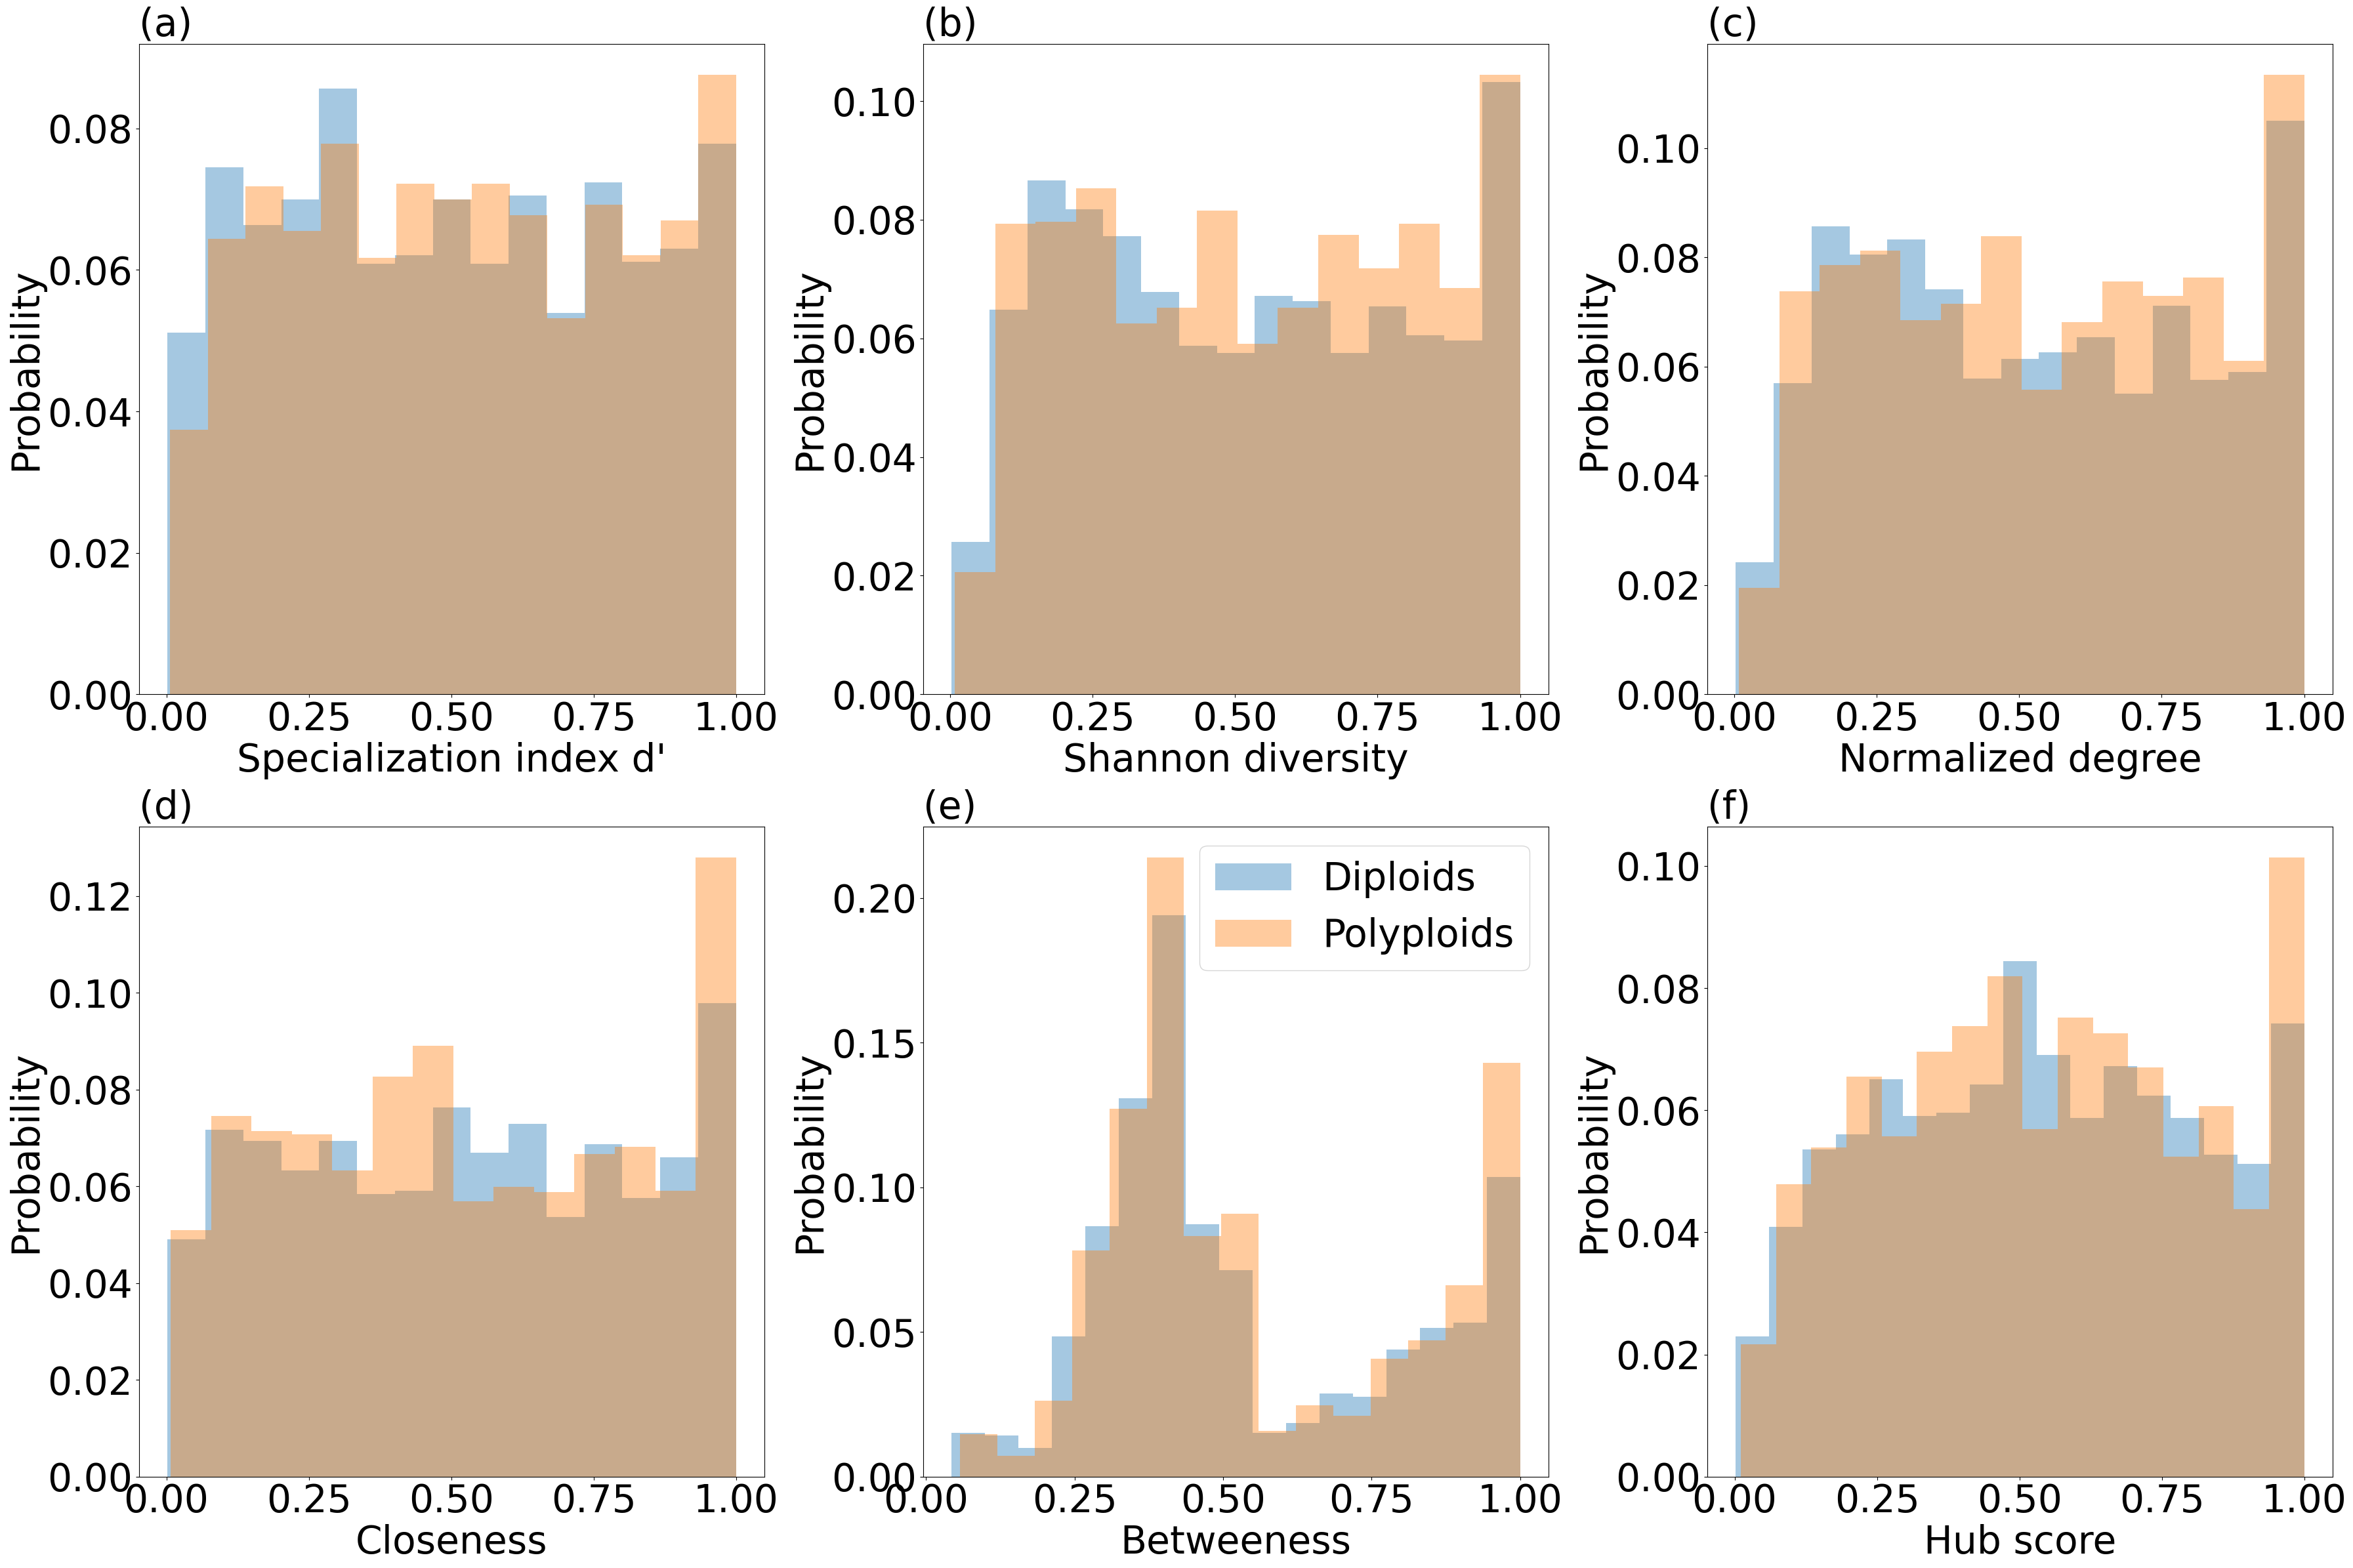

In [28]:
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "tab:orange"
di_color = "tab:blue"
alpha = 0.4

fig, ax = plt.subplots(figsize=(3*12, 2*12))
# fig.suptitle(f"Indices distribution across {features_by_ploidy.get_group('Polyploids').shape[0]:,} polyploids and {features_by_ploidy.get_group('Diploids').shape[0]:,} diploids", fontsize=fontsize)

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=2, fig=fig)
ax5 = plt.subplot2grid((2,6), (1,2), colspan=2, fig=fig)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2, fig=fig)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_d"], label="Diploids", color=di_color, ax=ax1, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_d"], label="Polyploids", ax=ax1, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax1.set_xlabel("Specialization index d'", fontsize=fontsize)
ax1.set_ylabel("Probability", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize)
ax1.set_title("(a)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_partner.diversity"], label="Diploids", color=di_color, ax=ax2, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_partner.diversity"], label="Polyploids", ax=ax2, color=poly_color, stat="probability",alpha=alpha, linewidth=0)
ax2.set_xlabel("Shannon diversity", fontsize=fontsize)
ax2.set_ylabel("Probability", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize)
ax2.set_title("(b)", loc="left", fontsize=fontsize)


sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_normalised.degree"], label="Diploids", color=di_color, ax=ax3, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_normalised.degree"], label="Polyploids", ax=ax3, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax3.set_xlabel("Normalized degree", fontsize=fontsize)
ax3.set_ylabel("Probability", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize)
ax3.set_title("(c)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_weighted.closeness"], label="Diploids", color=di_color, ax=ax4, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_weighted.closeness"], label="Polyploids", ax=ax4, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax4.set_xlabel("Closeness", fontsize=fontsize)
ax4.set_ylabel("Probability", fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.tick_params(axis='both', which='minor', labelsize=fontsize)
ax4.set_title("(d)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_weighted.betweenness"], label="Diploids", color=di_color, ax=ax5, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_weighted.betweenness"], label="Polyploids", ax=ax5, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax5.set_xlabel("Betweeness", fontsize=fontsize)
ax5.legend(prop={'size': fontsize})
ax5.set_ylabel("Probability", fontsize=fontsize)
ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.tick_params(axis='both', which='minor', labelsize=fontsize)
ax5.set_title("(e)", loc="left", fontsize=fontsize)


sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_hubbiness_score"], label="Diploids", color=di_color, ax=ax6, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_hubbiness_score"], label="Polyploids", ax=ax6, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax6.set_xlabel("Hub score", fontsize=fontsize)
ax6.set_ylabel("Probability", fontsize=fontsize)
ax6.tick_params(axis='both', which='major', labelsize=fontsize)
ax6.tick_params(axis='both', which='minor', labelsize=fontsize)
ax6.set_title("(f)", loc="left", fontsize=fontsize)

fig.tight_layout()
fig.savefig(f"../../../data/figures/fig1_{'weighted' if do_weighted else 'binary'}.jpeg")

/tmp/ipykernel_37295/1359977466.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


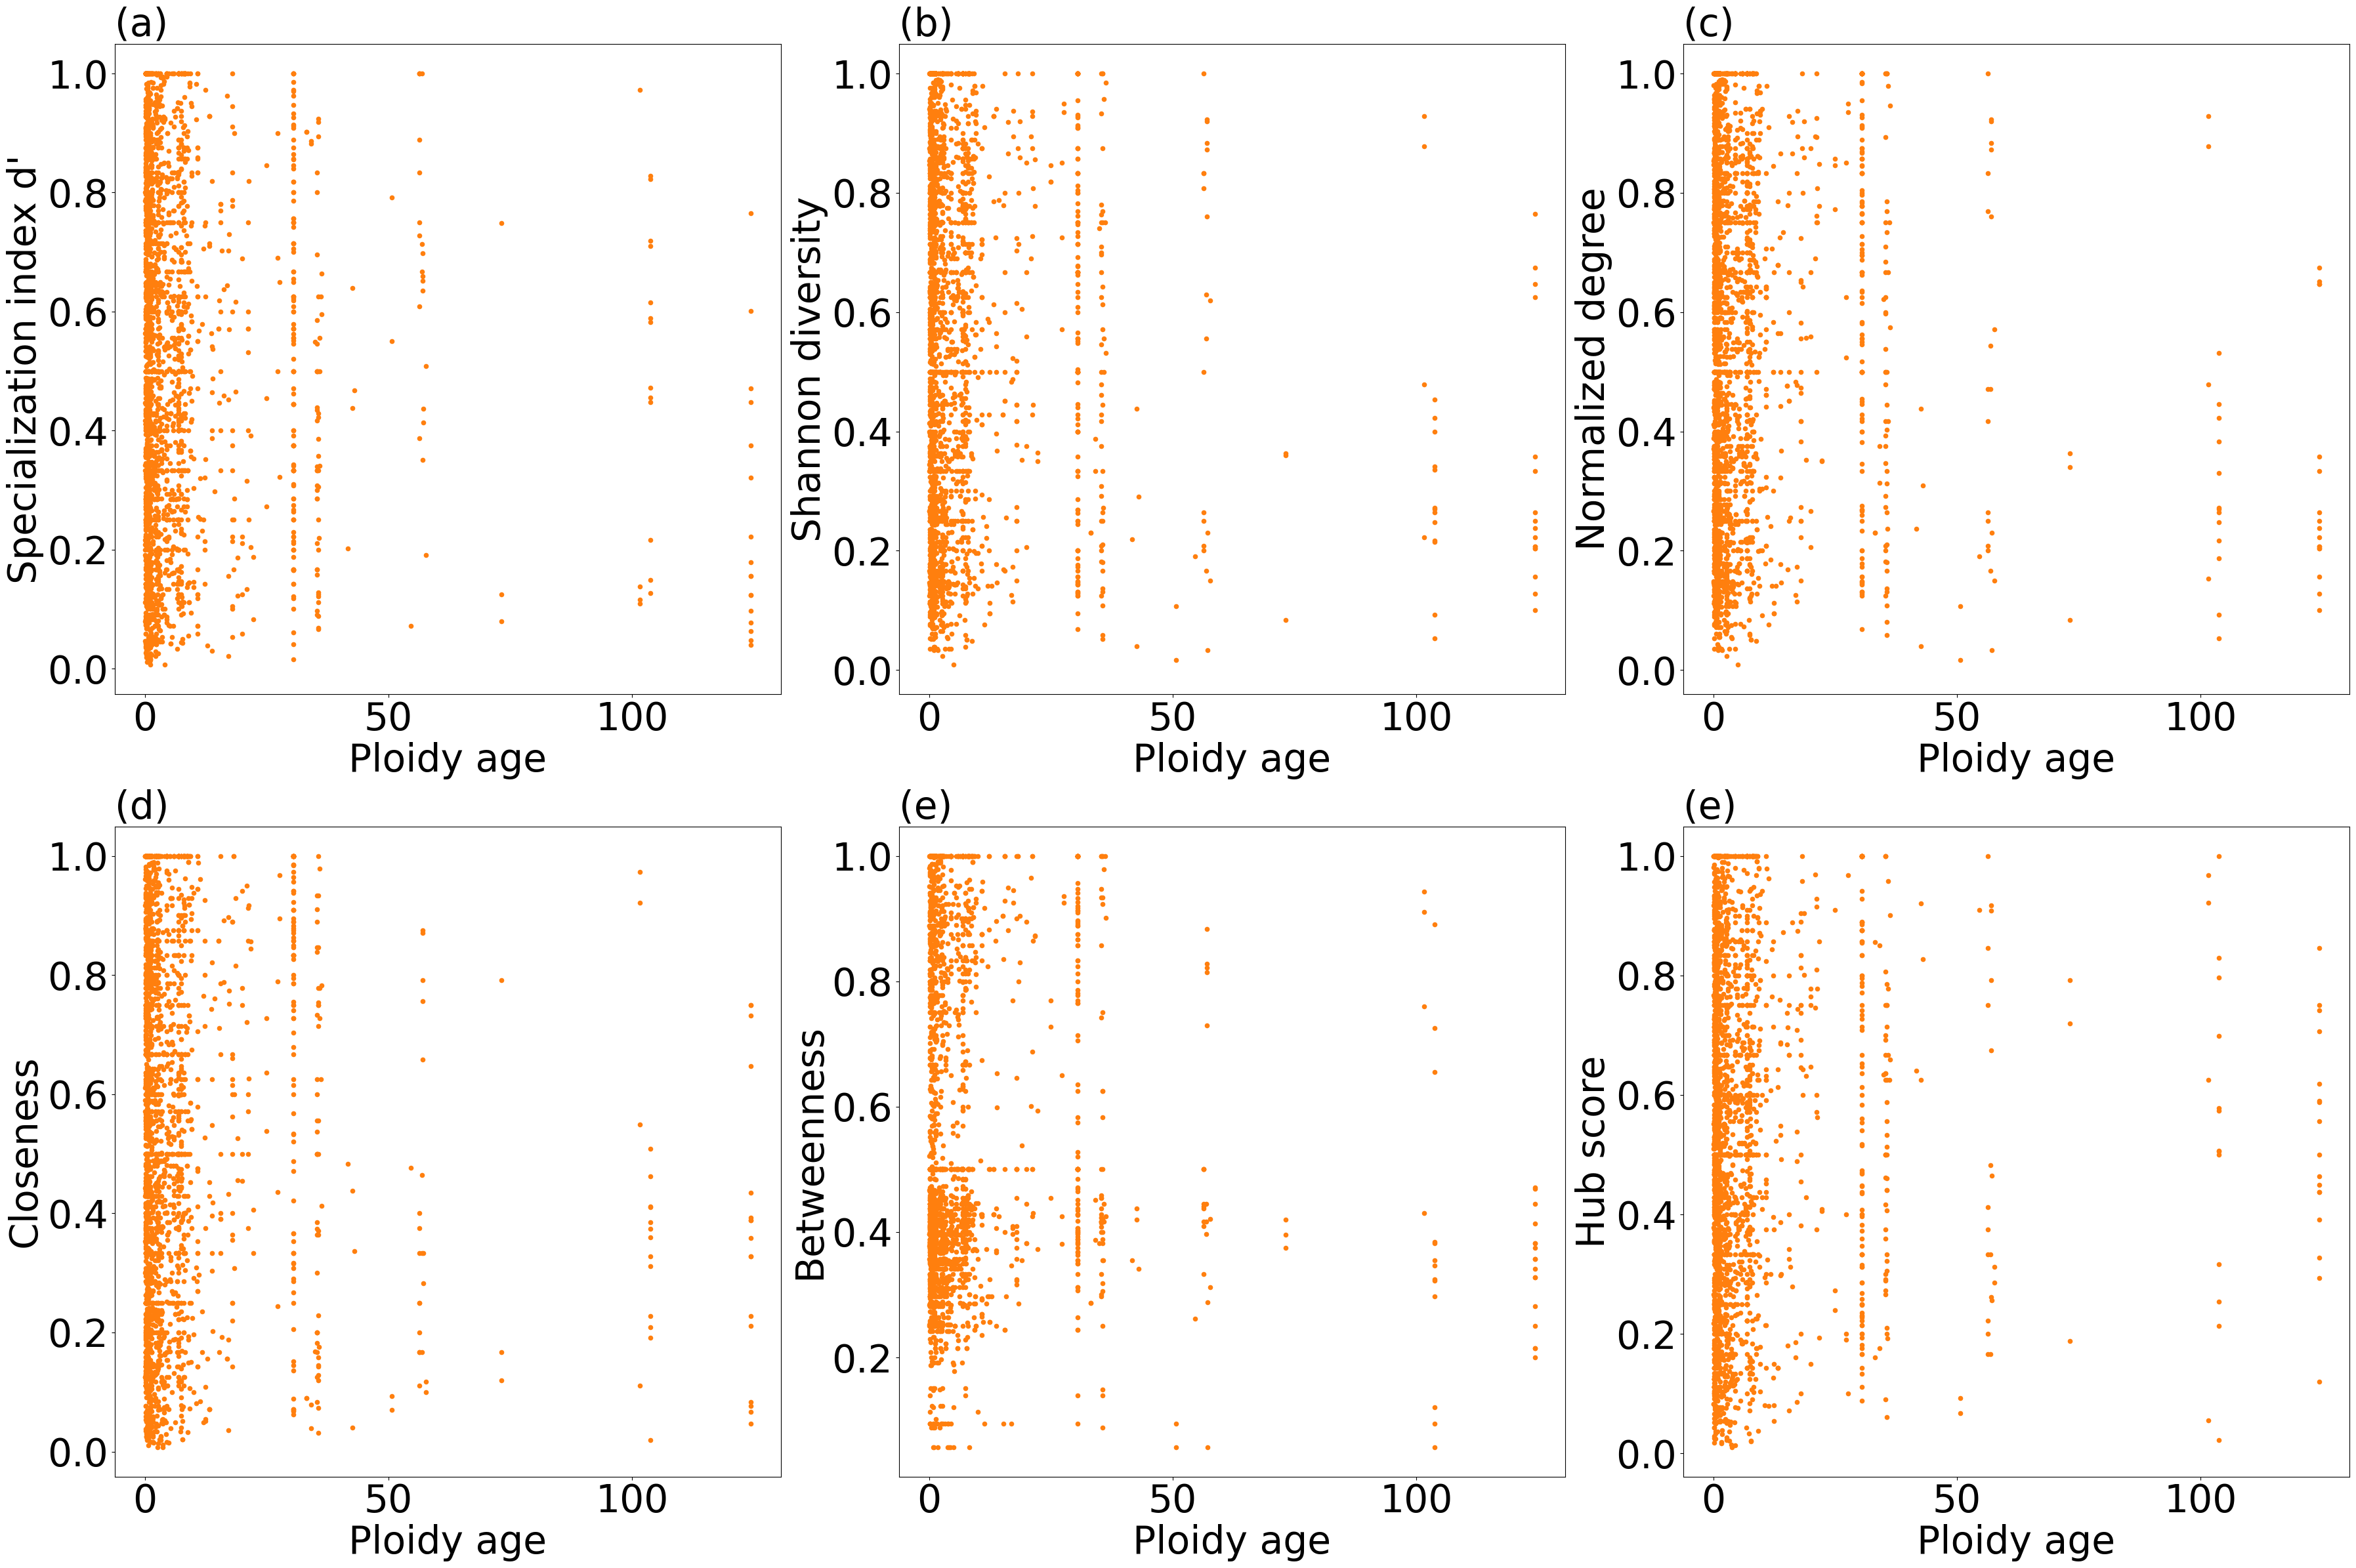

In [29]:
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "tab:orange"
di_color = "tab:blue"
alpha = 0.4

fig, ax = plt.subplots(figsize=(3*12, 2*12))
polyploids = features_by_ploidy.get_group("Polyploids")

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=2, fig=fig)
ax5 = plt.subplot2grid((2,6), (1,2), colspan=2, fig=fig)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2, fig=fig)


polyploids.plot.scatter(x="ploidy_age", y="standardized_d", color=poly_color, ax=ax1)
ax1.set_ylabel("Specialization index d'", fontsize=fontsize)
ax1.set_xlabel("Ploidy age", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.set_title("(a)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_partner.diversity", color=poly_color, ax=ax2)
ax2.set_ylabel("Shannon diversity", fontsize=fontsize)
ax2.set_xlabel("Ploidy age", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.set_title("(b)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_normalised.degree", color=poly_color, ax=ax3)
ax3.set_ylabel("Normalized degree", fontsize=fontsize)
ax3.set_xlabel("Ploidy age", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.set_title("(c)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_weighted.closeness", color=poly_color, ax=ax4)
ax4.set_ylabel("Closeness", fontsize=fontsize)
ax4.set_xlabel("Ploidy age", fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.set_title("(d)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_weighted.betweenness", color=poly_color, ax=ax5)
ax5.set_ylabel("Betweenness", fontsize=fontsize)
ax5.set_xlabel("Ploidy age", fontsize=fontsize)
ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.set_title("(e)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_hubbiness_score", color=poly_color, ax=ax6)
ax6.set_ylabel("Hub score", fontsize=fontsize)
ax6.set_xlabel("Ploidy age", fontsize=fontsize)
ax6.tick_params(axis='both', which='major', labelsize=fontsize)
ax6.set_title("(e)", loc="left", fontsize=fontsize)


fig.tight_layout()
fig.savefig(f"../../../data/figures/fig_pl_age_{'weighted' if do_weighted else 'binary'}.jpeg")

In [30]:
from scipy.stats import ks_2samp

for feature in relevant_features:
    if "standardized" in feature:
        continue
    dres = ks_2samp(features_by_ploidy.get_group("Diploids")[feature], features_by_ploidy.get_group("Polyploids")[feature])
    if dres.pvalue <= 0.05:
        print(f"# KS test for comparison of {feature} distribution across diploids and polyploids = {dres}")

# KS test for comparison of partner.diversity distribution across diploids and polyploids = KstestResult(statistic=0.04506529629206619, pvalue=0.004762879119111022)
# KS test for comparison of d distribution across diploids and polyploids = KstestResult(statistic=0.05385459779804605, pvalue=0.00036173162767663377)
# KS test for comparison of normalised.degree distribution across diploids and polyploids = KstestResult(statistic=0.07513934438117408, pvalue=1.0550832256055403e-07)
# KS test for comparison of weighted.betweenness distribution across diploids and polyploids = KstestResult(statistic=0.04677803792959041, pvalue=0.002987647078583048)
# KS test for comparison of weighted.closeness distribution across diploids and polyploids = KstestResult(statistic=0.0789022545281825, pvalue=1.891260213220357e-08)
# KS test for comparison of hubbiness_score distribution across diploids and polyploids = KstestResult(statistic=0.03822067490813106, pvalue=0.025833910623473722)


# add network-level metadata when available

In [117]:
final_features_with_classification = pd.read_csv(processed_data_path)
networks_metadata = pd.read_csv(networks_metadata_path)
networks_metadata_rel_cols = ['network_size', 'num_plants', 'num_pollinators', 'Annual Mean Temperature','Mean Diurnal Range (Mean of monthly (max temp - min temp))','Isothermality (BioClim_2/BioClim_7) (×100)','Temperature Seasonality (standard deviation ×100)','Max Temperature of Warmest Month','Min Temperature of Coldest Month','Temperature Annual Range (BioClim_5-BioClim_6)','Mean Temperature of Wettest Quarter','Mean Temperature of Driest Quarter','Mean Temperature of Warmest Quarter','Mean Temperature of Coldest Quarter','Annual Precipitation','Precipitation of Wettest Month','Precipitation of Driest Month','Precipitation Seasonality (Coefficient of Variation)','Precipitation of Wettest Quarter','Precipitation of Driest Quarter','Precipitation of Warmest Quarter','Precipitation of Coldest Quarter','Climate_PC1', 'Climate_PC2', 'Climate_PC3',
 'Annual Mean Temperature present at LGM (~22,000 years ago)','Max Temperature of Warmest Month present at LGM (~22,000 years ago)','Min Temperature of Coldest Month present at LGM (~22,000 years ago)','Temperature Annual Range (BioClim_5-BioClim_6) present at LGM (~22,000 years ago)','Mean Temperature of Wettest Quarter present at LGM (~22,000 years ago)','Mean Temperature of Driest Quarter present at LGM (~22,000 years ago)','Mean Temperature of Warmest Quarter present at LGM (~22,000 years ago)','Mean Temperature of Coldest Quarter present at LGM (~22,000 years ago)','Annual Precipitation present at LGM (~22,000 years ago)','Precipitation of Wettest Month present at LGM (~22,000 years ago)','Precipitation of Driest Month present at LGM (~22,000 years ago)','Precipitation Seasonality (Coefficient of Variation) present at LGM (~22,000 years ago)','Precipitation of Wettest Quarter present at LGM (~22,000 years ago)','Precipitation of Driest Quarter present at LGM (~22,000 years ago)','Precipitation of Warmest Quarter present at LGM (~22,000 years ago)','Precipitation of Coldest Quarter present at LGM (~22,000 years ago)','ChangeInClimate_PC1', 'ChangeInClimate_PC2', 'ChangeInClimate_PC3',
 'species_richness',
 'EcoRegion','EcoRegion_name','Altitude',
 'highest_pollinator_rank_index','highest_pollinator_rank_name',
 'Basal angiosperm %','Asterids %','Basal dicots %','Basal monocots %','Commelinids %','Rosids %','Taxonomy_PC1','Taxonomy_PC2','Taxonomy_PC3',
 'Woody %','Annual %','Perennial herb %','Lifeform_PC1','Lifeform_PC2','Lifeform_PC3',
 'Difference in glaciers','Current glaciers','LGM glaciers',
 'Polyploid percent','Biome frequency','Human footprint','Elevation amplitude','Binomial PV','NPP','Phosphorus retention', "ClimateZ", "climate_category"]
networks_metadata_rel_cols = set(networks_metadata_rel_cols) & set(networks_metadata.columns)
final_features_with_classification = final_features_with_classification[set(final_features_with_classification.columns)-set(networks_metadata_rel_cols)]

/var/tmp/pbs.211755.power9.tau.ac.il/ipykernel_313256/685956703.py:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  final_features_with_classification = final_features_with_classification[set(final_features_with_classification.columns)-set(networks_metadata_rel_cols)]


In [118]:
final_features_with_classification["network_index"] = final_features_with_classification.network_id.apply(lambda x: int(x.split("_")[-1]))

/var/tmp/pbs.211755.power9.tau.ac.il/ipykernel_313256/2740832110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["network_index"] = final_features_with_classification.network_id.apply(lambda x: int(x.split("_")[-1]))


In [119]:
final_features_with_classification = final_features_with_classification.merge(networks_metadata[["network_type", "network_index"] + list(networks_metadata_rel_cols)], on=["network_type", "network_index"], how="left")
final_features_with_classification = final_features_with_classification[[c for c in final_features_with_classification.columns if "Unnamed" not in c]]
final_features_with_classification = final_features_with_classification.drop_duplicates(subset=["original_name", "network_id"])
final_features_with_classification[networks_metadata_rel_cols].notna().sum() / final_features_with_classification.shape[0]

/var/tmp/pbs.211755.power9.tau.ac.il/ipykernel_313256/2903705745.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  final_features_with_classification[networks_metadata_rel_cols].notna().sum() / final_features_with_classification.shape[0]


species_richness                 0.859406
NPP                              0.859050
EcoRegion                        0.929525
Altitude                         0.859406
ChangeInClimate_PC2              0.859406
ChangeInClimate_PC1              0.859406
Climate_PC1                      0.859406
Taxonomy_PC2                     0.859406
Lifeform_PC2                     0.859406
Climate_PC2                      0.859406
num_plants                       1.000000
num_pollinators                  1.000000
highest_pollinator_rank_index    0.981135
EcoRegion_name                   0.943050
ChangeInClimate_PC3              0.859406
highest_pollinator_rank_name     0.981135
network_size                     1.000000
Taxonomy_PC3                     0.859406
Lifeform_PC1                     0.859406
ClimateZ                         0.907279
Lifeform_PC3                     0.859406
Climate_PC3                      0.859406
Taxonomy_PC1                     0.859406
climate_category                 0

In [120]:
final_features_with_classification.loc[final_features_with_classification.species_richness%1 != 0, "species_richness"] = final_features_with_classification.species_richness.apply(lambda x: np.exp(x)-1)
final_features_with_classification.to_csv(processed_data_path, index=False)

# add flag to ploidy variability within species based on chromosome numbers from ccdb

In [121]:
final_features_with_classification = pd.read_csv(processed_data_path)
ccdb = pd.read_csv(ccdb_path)
ccdb.mapped_name = ccdb.mapped_name.str.replace("-", " ")

In [122]:
# TO DO: maybe set a continnuos measure that will enable a threshold based decision of inclusion / exclusion
def get_ploidy_variablity_flag(chromosome_counts: pd.Series) -> bool:
    chromosome_counts = chromosome_counts.dropna()
    min_cc = np.min(chromosome_counts)
    max_cc = np.max(chromosome_counts)
    if max_cc > int(min_cc*1.5):
        return True
    return False

name_to_ploidy_variablity_flag = ccdb.groupby("mapped_name")["parsed_n"].apply(get_ploidy_variablity_flag).reset_index().rename(columns={"parsed_n": "has_ploidy_variability"})

In [123]:
final_features_with_classification = final_features_with_classification.merge(name_to_ploidy_variablity_flag, left_on="resolved_name", right_on="mapped_name", how="left")
d = name_to_ploidy_variablity_flag.set_index("mapped_name")["has_ploidy_variability"].to_dict()
final_features_with_classification.loc[final_features_with_classification.has_ploidy_variability.isna(), "has_ploidy_variability"] = final_features_with_classification.original_name.apply(lambda n: d.get(n, np.nan))

In [124]:
print(f"# species with no ploidy level variability = {final_features_with_classification.query('has_ploidy_variability == 0').shape[0]}")
print(f"% species with no ploidy level variability = {np.round(final_features_with_classification.query('has_ploidy_variability == 0').shape[0]/final_features_with_classification.shape[0]*100,2)}%")

# species with no ploidy level variability = 2396
% species with no ploidy level variability = 42.64%


In [125]:
final_features_with_classification.to_csv(processed_data_path, index=False)

# add species-level metadata where available

In [126]:
final_features_with_classification = pd.read_csv(processed_data_path)

In [127]:
species_mating_system_data = pd.read_excel(species_mating_system_data_path, header=1, sheet_name="Table S3")
nr_unresolved = pd.read_csv(f"{os.path.dirname(species_mating_system_data_path)}/temp_nr_mating_system_data_path/unresolved_names.csv")
nr_resolved = pd.read_csv(f"{os.path.dirname(species_mating_system_data_path)}/temp_nr_mating_system_data_path/resolved_names.csv")
species_mating_system_data = species_mating_system_data.merge(nr_unresolved[["Name", "Id"]], left_on="OrigSpecies", right_on="Name", how="left")
species_mating_system_data = species_mating_system_data.merge(nr_resolved[["Id", "Coded Name", "Matched Name"]], on="Id", how="left").rename(columns={"Coded Name": "resolved_name",                                                                                                                                                  "Matched Name": "matched_name"})
species_mating_system_data.resolved_name = species_mating_system_data.resolved_name.str.replace("_", " ")
species_mating_system_data["species"] = species_mating_system_data.AccGenus.str.lower() + " " + species_mating_system_data.AccSpecies.str.lower()
species_mating_system_data.OrigSpecies = species_mating_system_data.OrigSpecies.str.lower()
species_mating_system_data.resolved_name = species_mating_system_data.resolved_name.str.lower()
species_mating_system_data.matched_name = species_mating_system_data.matched_name.str.lower()

sp_to_ms = species_mating_system_data.set_index('species')['bs'].to_dict()
orig_name_to_ms = species_mating_system_data.set_index('OrigSpecies')['bs'].to_dict()
resolved_name_to_ms = species_mating_system_data.dropna(subset=["resolved_name", "bs"]).set_index('resolved_name')['bs'].to_dict()

In [128]:
species_metadata_1 = pd.read_excel(species_metadata_path_1, header=1)
species_metadata_1.Species = species_metadata_1.Species.str.lower().str.replace("_"," ")

In [129]:
species_metadata_2 = pd.read_excel(species_metadata_path_2)
species_metadata_2['Accepted Name'] = species_metadata_2['Accepted Name'].str.lower().str.replace("_"," ")

In [130]:
species_metadata_3 = pd.read_excel(species_metadata_path_3, sheet_name="Data")
species_metadata_3 = species_metadata_3.rename(columns={c: c.replace("ASTh", "AST_h").replace("ASTf", "AST_f") for c in species_metadata_3.columns})
relevant_cols = list(set([c for c in species_metadata_3.columns if not c.endswith("SOURCE")])-{"scientificName_WFO", "comments", "genus", "is_polyploid", "data_collector_initials", "ASTonly_flw_len_unit"})
species_metadata_3 = species_metadata_3[relevant_cols]
species_metadata_3.scientificName = species_metadata_3.scientificName.str.lower()
for c in species_metadata_3.columns:
    if "len" in c:
        species_metadata_3[c] = species_metadata_3[c].replace({"save": np.nan})
        if not is_numeric_dtype(species_metadata_3[c]):
            species_metadata_3[c] = species_metadata_3[c].apply(lambda x: float(str(x).replace("..", ".")))
        species_metadata_3[c] = species_metadata_3[c].astype(float)
# correct head data for Astereacea members, in case of nans
species_metadata_3.loc[(species_metadata_3.flw_len_mean_AST_head_level.isna()) & (species_metadata_3.family == "Asteraceae"), "flw_len_mean_AST_head_level"] = 2*species_metadata_3.flw_len_mean_AST_floret_level
species_metadata_3.loc[(species_metadata_3.flw_len_min_AST_head_level.isna()) & (species_metadata_3.family == "Asteraceae"), "flw_len_min_AST_head_level"] = 2*species_metadata_3.flw_len_min_AST_floret_level
species_metadata_3.loc[(species_metadata_3.flw_len_max_AST_head_level.isna()) & (species_metadata_3.family == "Asteraceae"), "flw_len_max_AST_head_level"] = 2*species_metadata_3.flw_len_max_AST_floret_level                                 

/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [131]:
final_features_with_classification = final_features_with_classification[list(set(final_features_with_classification.columns)-set(species_metadata_3.columns))]

In [132]:
final_features_with_classification["merge_name"] = final_features_with_classification.apply(lambda rec: rec.resolved_name if pd.notna(rec.resolved_name) else rec.Plant, axis=1).str.lower()
final_features_with_classification = final_features_with_classification.merge(species_metadata_3, left_on="merge_name", right_on="scientificName", how="left")
final_features_with_classification = final_features_with_classification.drop(["scientificName", "family", "merge_name"], axis=1)

In [133]:
final_features_with_classification[[c for c in final_features_with_classification.columns if c.startswith("flw_")]].notna().sum()

flw_color                        5474
flw_len_mean_AST_head_level      4866
flw_shape_AST_head_level         5480
flw_len_max_AST_head_level       4236
flw_len_mean_AST_floret_level    4831
flw_shape_AST_floret_level       4175
flw_symmetry_AST_head_level      5457
flw_len_min_AST_floret_level     4191
flw_len_max_AST_floret_level     4198
flw_len_min_AST_head_level       4229
flw_symmetry_AST_floret_level    5457
dtype: int64

In [134]:
final_features_with_classification.to_csv(processed_data_path)

## mating system data

In [135]:
final_features_with_classification = final_features_with_classification.drop([c for c in final_features_with_classification.columns if c.endswith("_x")], axis=1)
final_features_with_classification = final_features_with_classification.rename(columns={c: c.replace("_y","") for c in final_features_with_classification.columns if c.endswith("_y")})

In [136]:
final_features_with_classification["resolved_species"] = final_features_with_classification.resolved_name.apply(lambda x: " ".join(x.split(" ")[:2]) if pd.notna(x) else x)
final_features_with_classification["mating_system"] = np.nan
final_features_with_classification.loc[final_features_with_classification.mating_system.isna(), "mating_system"] = final_features_with_classification.resolved_species.apply(lambda x: sp_to_ms.get(x, np.nan))
final_features_with_classification.loc[final_features_with_classification.mating_system.isna(), "mating_system"] = final_features_with_classification.original_name.apply(lambda x: orig_name_to_ms.get(x, np.nan))
final_features_with_classification.loc[final_features_with_classification.mating_system.isna(), "mating_system"] = final_features_with_classification.resolved_name.apply(lambda x: resolved_name_to_ms.get(x, np.nan))

In [137]:
final_features_with_classification.mating_system = final_features_with_classification[["mating_system", "mating_system_literature"]].apply(lambda rec: rec.dropna().values[0] if len(rec.dropna().values) > 0 else np.nan, axis=1)
final_features_with_classification = final_features_with_classification.drop(["mating_system_literature"], axis=1)
final_features_with_classification.mating_system = final_features_with_classification.mating_system.replace({"dioecious": "SI",
                                                                                                             "monoecious": "SC"})
print(f"# samples with mating system data = {final_features_with_classification.mating_system.notna().sum():,}")

# samples with mating system data = 2,884


In [138]:
final_features_with_classification.mating_system = final_features_with_classification.mating_system.fillna("unknown")
final_features_with_classification.to_csv(processed_data_path, index=False)

## growth and life form data

In [139]:
final_features_with_classification = final_features_with_classification.merge(species_metadata_1, left_on="resolved_name", right_on="Species", how="left")

In [140]:
display(final_features_with_classification[set(species_metadata_1.columns)&set(final_features_with_classification.columns)].notna().sum())

/var/tmp/pbs.211755.power9.tau.ac.il/ipykernel_313256/2167538041.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  display(final_features_with_classification[set(species_metadata_1.columns)&set(final_features_with_classification.columns)].notna().sum())


Species        5105
Growth_form    5036
Lifeform       5105
Life_cycle     4921
dtype: int64

In [141]:
final_features_with_classification = final_features_with_classification.merge(species_metadata_2, left_on="resolved_name", right_on="Accepted Name", how="left")

In [142]:
lf_mapping = pd.read_excel(lf_mapping_path).set_index(["Anna", "Raunkiaer"]).Result.to_dict()

In [143]:
final_features_with_classification.Lifeform = final_features_with_classification.Lifeform.replace({"unclassifiedperennial": "Unclassified perennial",
                                                                                                   "unclassifiedherb": "Unclassified herb"})

In [144]:
final_features_with_classification["new_Lifeform"] = final_features_with_classification.Lifeform.replace({"perennialmixed": np.nan, "mixedherb": np.nan, "Unclassified perennial": np.nan, "Unclassified herb": np.nan})
final_features_with_classification.loc[final_features_with_classification.new_Lifeform.isna(), "new_Lifeform"] = final_features_with_classification[["new_Lifeform", "Lifeform", "Raunkiaer_LifeForm"]].apply(lambda rec: lf_mapping.get((rec.Lifeform, rec.Raunkiaer_LifeForm), np.nan), axis=1)
final_features_with_classification.loc[final_features_with_classification.new_Lifeform.isna(), "new_Lifeform"] = final_features_with_classification.Lifeform
final_features_with_classification = final_features_with_classification.rename(columns={"Lifeform": "Anna_Lifeform",
                                                                                        "new_Lifeform": "Lifeform"})
final_features_with_classification.Lifeform = final_features_with_classification.Lifeform.replace({"perennialherb": "perennial_herb",
                                                                                                   "Unclassified perennial": "unclassified_perennial",
                                                                                                   "mixedherb": "mixed_herb",
                                                                                                   "perennialmixed": "perennial_mixed",
                                                                                                   "Unclassified perennial": "unclassified_perennial"})
final_features_with_classification.to_csv(processed_data_path, index=False)

In [145]:
final_features_with_classification["LifeCycle"] = final_features_with_classification["LifeCycle"].fillna(final_features_with_classification["Life_cycle"])
final_features_with_classification = final_features_with_classification.drop(["Life_cycle", "Accepted Name"], axis=1)

In [146]:
unclass = final_features_with_classification.loc[final_features_with_classification.Lifeform.str.contains("unclass", na=False)][["original_name", "resolved_name", "LifeCycle", "Growth_form", "Lifeform", "Raunkiaer_LifeForm"]].drop_duplicates()
unclass.to_csv("unclassified_lifeforms.csv")
mixed = final_features_with_classification.loc[final_features_with_classification.Lifeform.str.contains("mixed", na=False)][["original_name", "resolved_name", "LifeCycle", "Growth_form", "Lifeform", "Raunkiaer_LifeForm"]].drop_duplicates()
mixed.to_csv("mixed_lifeforms.csv")

In [147]:
final_features_with_classification.Lifeform = final_features_with_classification.Lifeform.str.lower()

In [148]:
final_features_with_classification["Woodiness"] = final_features_with_classification["Woodiness"].replace({"Non-Woody": "herb", "Woody": "woody"}).fillna(final_features_with_classification["Growth_form"])
final_features_with_classification = final_features_with_classification.drop(["Growth_form"], axis=1)
final_features_with_classification = final_features_with_classification.rename(columns={"Woodiness": "Growth_form"})

In [149]:
final_features_with_classification[set(["original_name", "resolved_name"] + 
                                   [c for c in species_metadata_1.columns if c in final_features_with_classification.columns] + 
                                   [c for c in species_metadata_2.columns if c in final_features_with_classification.columns])].head()

/var/tmp/pbs.211755.power9.tau.ac.il/ipykernel_313256/1271131495.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  final_features_with_classification[set(["original_name", "resolved_name"] +


,Family,Lifeform,Raunkiaer_LifeForm,Growth_form,Genus,USDA_Definitions,LifeCycle,original_name,resolved_name,Species
0,Elaeocarpaceae,woody,Phanerophyte AND Nanophanerophyte,woody,Aristotelia,Shrub,Perennial,aristotelia chilensis,aristotelia chilensis,aristotelia chilensis
1,Alstroemeriaceae,perennial herb,Geophyte,herb,Alstroemeria,Herb,Perennial,alstroemeria aurea,alstroemeria aurea,alstroemeria aurea
2,Berberidaceae,woody,Nanophanerophyte,woody,Berberis,Shrub,Perennial,berberis darwinii,berberis darwinii,berberis darwinii
3,Fabaceae,perennial herb,Hemicryptophyte,herb,Vicia,NaN,Perennial,vicia nigricans,vicia nigricans,vicia nigricans
4,Grossulariaceae,woody,Nanophanerophyte,woody,Ribes,Shrub,Perennial,ribes magellanicum,ribes magellanicum,ribes magellanicum


In [150]:
def complement_lifeform(record: pd.Series):
    gf = record.Growth_form
    lc = record.LifeCycle
    rank = record.Raunkiaer_LifeForm
    if lc == "annual":
        return "annual"
    elif gf == "woody":
        return "woody"
    elif rank == "Therophyte":
        return "annual"
    else:
        if lc == "herb" or rank in ["Chamaephyte", "Hemicryptophyte"]:
            return "perennial herb"
    if lc == "herb":
        return "unclassified herb"
    return record.Lifeform

def classify_lifeform(record:pd.Series):
    lf = record.Lifeform
    gf = record.Growth_form
    lc = record.LifeCycle
    if pd.notna(lf) and lf.endswith("perennial"): 
        if pd.notna(gf) and gf == "herb":
            return "perennial herb"
        elif pd.notna(gf) and gf == "mixed":
            return "perennial mixed"
    elif pd.notna(lf) and lf.endswith("herb"):
        if pd.notna(lc) and lc == "Perennial":
            return "perennial herb"
        elif pd.notna(lc) and lc == "mixed":
            return "mixed herb"
    return lf
    
            
final_features_with_classification.LifeCycle = final_features_with_classification.LifeCycle.str.lower()
final_features_with_classification.Growth_form = final_features_with_classification.Growth_form.str.lower()
final_features_with_classification.loc[final_features_with_classification.Lifeform.isna(), "Lifeform"] = final_features_with_classification.apply(complement_lifeform, axis=1)
final_features_with_classification.loc[final_features_with_classification.Lifeform.str.startswith("unclassified", na=True), "Lifeform"] = final_features_with_classification.apply(classify_lifeform, axis=1)

In [151]:
final_features_with_classification.query("Lifeform.str.contains('mixed', na=False)")[["resolved_name", "Lifeform", "Growth_form", "LifeCycle", "Raunkiaer_LifeForm"]].to_csv("mixed_lifeforms_for_categorization.csv", index=False)

In [152]:
final_features_with_classification.groupby("Growth_form").Plant.count()

Growth_form
conflict       2
herb        4593
mixed         65
woody        719
Name: Plant, dtype: int64

In [153]:
final_features_with_classification.loc[final_features_with_classification.Growth_form.isna()][["resolved_name"]].drop_duplicates()

,resolved_name
46,rhynchosia minima
65,NaN
516,rhinanthus glacialis
695,alchemilla vulgaris
1110,carduus pycnocephalus subsp. albidus
...,...
4478,pimelea traversii
4511,leucheria landbeckii
4649,ourisia caespitosa
4665,viola montagnei


In [154]:
final_features_with_classification.query("Lifeform.str.startswith('unclass', na=True)")[["resolved_name", "Lifeform", "Growth_form","Raunkiaer_LifeForm", "LifeCycle"]].drop_duplicates().to_csv("sp_for_lifeform_complementing.csv", index=False)

In [155]:
def get_lf(rec: pd.Series) -> str:
    if pd.notna(rec.Growth_form) and rec.Growth_form == "herb" and pd.notna(rec.LifeCycle) and "nial" in rec.LifeCycle:
        return "perennial_herb"
    elif pd.notna(rec.Growth_form) and rec.Growth_form != "herb":
        return "woody"
    elif pd.notna(rec.LifeCycle) and not "nial" in rec.LifeCycle:
        return "annual"
    return np.nan

lf_manual_classification = pd.read_csv(lf_manual_classification_path, encoding="latin1")
lf_manual_classification.Growth_form.replace({"herb ": "herb",
                                         "Herb": "herb",
                                         "shrub\xa0": "woody",
                                         "herb\xa0": "herb",
                                         "shrub": "woody",
                                         "shrub ": "woody"}, inplace=True)
lf_manual_classification.Growth_form = lf_manual_classification.Growth_form.str.lower()
lf_manual_classification.LifeCycle = lf_manual_classification.LifeCycle.str.lower()
lf_manual_classification["complemented_lf"] = lf_manual_classification.apply(get_lf, axis=1)
lf_manual_classification["my_lf"] = lf_manual_classification.resolved_name.apply(lambda n: final_features_with_classification.loc[final_features_with_classification.resolved_name == n, "Lifeform"].values[0] if final_features_with_classification.loc[final_features_with_classification.resolved_name == n, "Lifeform"].shape[0] > 0 else np.nan)
lf_manual_classification.my_lf = lf_manual_classification.my_lf.replace({"unclassified_perennial": np.nan,
                                                                         "unclassified_herb": np.nan})
lf_manual_classification["Lifeform"] = lf_manual_classification.apply(lambda rec: rec.my_lf if pd.notna(rec.my_lf) else rec.complemented_lf, axis=1)
resolved_name_to_lf = lf_manual_classification.dropna(subset=["Lifeform"]).set_index("resolved_name")["Lifeform"].to_dict()
name_to_gf = lf_manual_classification.set_index("resolved_name")["Growth_form"].to_dict()
name_to_lf = lf_manual_classification.set_index("resolved_name")["Lifeform"].to_dict()
name_to_lc = lf_manual_classification.set_index("resolved_name")["LifeCycle"].to_dict()

final_features_with_classification.loc[final_features_with_classification.resolved_name.isin(resolved_name_to_lf), "Lifeform"] = final_features_with_classification.resolved_name.apply(lambda n: resolved_name_to_lf.get(n, np.nan))
final_features_with_classification[(final_features_with_classification.Growth_form.isin(["mixed", "conflict"])) & (final_features_with_classification.Lifeform == "woody")] = "woody"
final_features_with_classification[(final_features_with_classification.Growth_form.isin(["mixed", "conflict"])) & (final_features_with_classification.Lifeform == "perennial_herb")] = "herb"
final_features_with_classification[(final_features_with_classification.Growth_form.isna()) & (final_features_with_classification.Lifeform == "woody")] = "woody"
final_features_with_classification[(final_features_with_classification.Growth_form.isna()) & (final_features_with_classification.Lifeform == "perennial_herb")] = "herb"									
final_features_with_classification.Growth_form = final_features_with_classification.apply(lambda rec: name_to_gf.get(rec.resolved_name, rec.Growth_form), axis=1)
final_features_with_classification.Lifeform = final_features_with_classification.apply(lambda rec: name_to_lf.get(rec.resolved_name, rec.Lifeform), axis=1)
final_features_with_classification.LifeCycle = final_features_with_classification.apply(lambda rec: name_to_lc.get(rec.resolved_name, rec.LifeCycle), axis=1)
final_features_with_classification.Growth_form = final_features_with_classification.apply(lambda rec: name_to_gf.get(rec.Plant, rec.Growth_form), axis=1)
final_features_with_classification.Lifeform = final_features_with_classification.apply(lambda rec: name_to_lf.get(rec.Plant, rec.Lifeform), axis=1)
final_features_with_classification.LifeCycle = final_features_with_classification.apply(lambda rec: name_to_lc.get(rec.Plant, rec.LifeCycle), axis=1)
final_features_with_classification = final_features_with_classification.drop_duplicates(["sample_id"], keep="first")
final_features_with_classification.to_csv(processed_data_path, index=False)

In [156]:
final_features_with_classification.to_csv(processed_data_path, index=False)

## flower trait data

In [157]:
final_features_with_classification = final_features_with_classification[[c for c in final_features_with_classification.columns if not c.endswith("_y")]]
final_features_with_classification = final_features_with_classification.rename(columns={c: c.replace("_x", "") for c in final_features_with_classification.columns if c.endswith("_x")})
final_features_with_classification = final_features_with_classification.loc[:, ~final_features_with_classification.columns.duplicated()]

In [158]:
final_features_with_classification[list(set(final_features_with_classification.columns)&set(relevant_cols)) + ["mating_system"]].notna().sum()

flw_color                        5402
n_flw_infl_AST_floret_level      5407
flw_len_mean_AST_head_level      4825
flw_shape_AST_head_level         5408
flw_len_max_AST_head_level       4214
flw_len_mean_AST_floret_level    4790
flw_shape_AST_floret_level       4115
flw_symmetry_AST_head_level      5385
flw_len_min_AST_floret_level     4169
flw_len_max_AST_floret_level     4176
flw_len_min_AST_head_level       4207
flw_symmetry_AST_floret_level    5385
n_flw_infl_AST_head_level        5407
mating_system                    5547
dtype: int64

In [159]:
for c in final_features_with_classification.columns:
    if "n_flw_infl" in c:
        final_features_with_classification[c] = final_features_with_classification[c].replace({"sinlgle": "single"})

In [160]:
final_features_with_classification = final_features_with_classification.loc[~final_features_with_classification.is_polyploid.isin(["woody", "herb"])]

In [161]:
for feat in list(set(final_features_with_classification.columns)&set(relevant_cols)) + ["mating_system"]:
    if len(final_features_with_classification[feat].unique()) < 10:
        if final_features_with_classification[feat].dtype == object:
            final_features_with_classification[feat] = final_features_with_classification[feat].str.replace(" ", "")
        display(final_features_with_classification.groupby(feat).Plant.count())
        print("\n\n")

n_flw_infl_AST_floret_level
multiple    4987
single       418
Name: Plant, dtype: int64

flw_shape_AST_head_level
restrictive      2203
unrestrictive    3203
Name: Plant, dtype: int64

flw_shape_AST_floret_level
restrictive      2260
unrestrictive    1853
Name: Plant, dtype: int64

flw_symmetry_AST_head_level
actinomorphic    4064
zygomorphic      1319
Name: Plant, dtype: int64

flw_symmetry_AST_floret_level
actinomorphic    3034
zygomorphic      2349
Name: Plant, dtype: int64

n_flw_infl_AST_head_level
multiple    3619
single      1786
Name: Plant, dtype: int64

mating_system
SC              1127
SI              1545
partially_SC     186
unknown         2687
Name: Plant, dtype: int64

In [162]:
final_features_with_classification.to_csv(processed_data_path, index=False)

# plot indices distrbiution across subgroups of covariates categories

In [176]:
df = pd.read_csv(processed_data_path)
df["is_polyploid"] = df.is_polyploid.replace({0: "Diploids", 1: "Polyploids"})
df.has_ploidy_variability.fillna(False)
df.has_ploidy_variability = df.has_ploidy_variability.astype(np.float64)
full_dataset = df
rel_cols = ["network_index", "has_ploidy_variability", "Lifeform"] + [c for c in df.columns if "flw_" in c]
limited_dataset = df.dropna(subset=rel_cols) # "flw_len_mean",
print(f"# samples in full dataset = {full_dataset.shape[0]:,}")
print(f"# samples in reduced dataset = {limited_dataset.shape[0]:,}")

# samples in full dataset = 5,517
# samples in reduced dataset = 3,010


In [177]:
df.Lifeform = df.Lifeform.replace({"unclassifiedherb": np.nan, "unclassifiedperennial": np.nan})
df[rel_cols].notna().sum()

network_index                    5517
has_ploidy_variability           5517
Lifeform                         5266
flw_len_max_AST_floret_level     4155
flw_shape_AST_head_level         5378
n_flw_infl_AST_head_level        5377
flw_len_mean_AST_head_level      4795
n_flw_infl_AST_floret_level      5377
flw_len_min_AST_floret_level     4148
flw_len_min_AST_head_level       4186
flw_symmetry_AST_floret_level    5355
flw_len_mean_AST_floret_level    4760
flw_shape_AST_floret_level       4089
flw_color                        5372
flw_symmetry_AST_head_level      5355
flw_len_max_AST_head_level       4193
dtype: int64

In [178]:
df = limited_dataset
df.has_ploidy_variability = df.has_ploidy_variability.astype(bool) 

/tmp/ipykernel_37295/4145142102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.has_ploidy_variability = df.has_ploidy_variability.astype(bool)


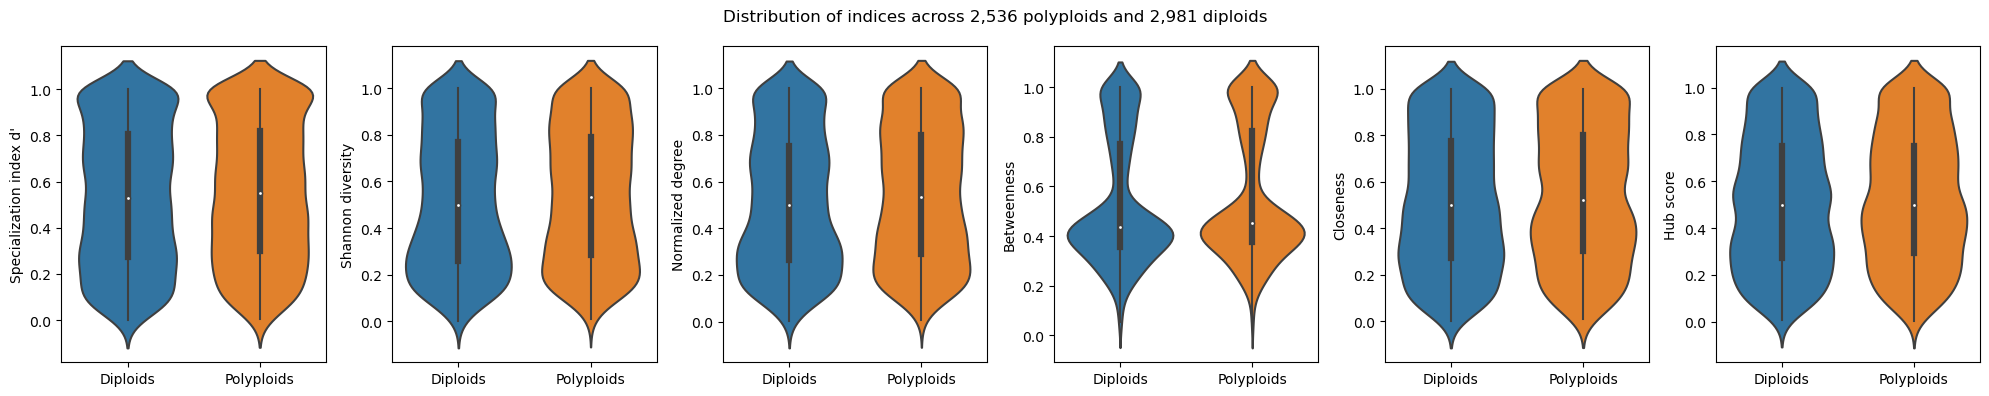

In [179]:
feature_col_to_name = {"standardized_d": "Specialization index d'",
                       "standardized_partner.diversity": "Shannon diversity",
                       "standardized_normalised.degree": "Normalized degree",
                       "standardized_weighted.betweenness": "Betweenness",
                       "standardized_weighted.closeness": "Closeness",
                       "standardized_hubbiness_score": "Hub score"}
features = ["standardized_d", "standardized_partner.diversity", "standardized_normalised.degree",
            "standardized_weighted.betweenness", "standardized_weighted.closeness", "standardized_hubbiness_score"]

fig, ax = plt.subplots(nrows=1, ncols=len(feature_col_to_name), figsize=(20,4))
i = 0
for feat in features:
    sns.violinplot(data=full_dataset, x="is_polyploid", y=feat, ax=ax[i])
    ax[i].set_ylabel(feature_col_to_name[feat])
    ax[i].set_xlabel("")
    i += 1

fig.suptitle(f"Distribution of indices across {full_dataset.loc[full_dataset.is_polyploid == 'Polyploids'].shape[0]:,} polyploids and {full_dataset.loc[full_dataset.is_polyploid == 'Diploids'].shape[0]:,} diploids")
fig.tight_layout()
fig.savefig("../../../data/figures/distribution_of_indices_baseline_full_dataset.jpeg")

In [180]:
def plot_hist_dist_across_var_cat(df: pd.DataFrame, varname: str, outpath: str):
    if varname == "":
        cat = ["all"]
    else:
        subdf = df.dropna(subset=[varname])
        try:
            df[varname].astype(int)
        except Exception as e:
            print(e)
            subdf = subdf.loc[~subdf[varname].str.contains("class")]
        cat = subdf[varname].unique().tolist()
    
    fig, ax = plt.subplots(nrows=len(cat), ncols=len(feature_col_to_name), figsize=(20,4*len(cat)))

    i, j = 0, 0
    for c in cat:
        for feat in features:
            if c == "all":
                data = df
                a = ax[j]
            else:
                data = df.loc[df[varname] == c]
                a = ax[i][j]
            npoly = data.loc[data.is_polyploid == "Polyploids"].shape[0]
            ndi = data.loc[data.is_polyploid == "Diploids"].shape[0]
            
            data.groupby(['is_polyploid'])[feat].plot.hist(alpha=0.5,  ax=a, density=True, stacked=True, legend=(j==len(features)-1))
            a.set_xlabel(feature_col_to_name[feat])
            a.set_ylabel("Freuqency")
            if varname != "":
                a.set_title(f"{varname}={c}\n({npoly:,} polyploids, {ndi:,} diploids)")
            else:
                a.set_title(f"({npoly:,} polyploids, {ndi:,} diploids)")
             
            j += 1
        i += 1
        j = 0
                                
    nsamples = df.shape[0]
    if varname != "":
        nsamples = df.dropna(subset=[varname]).shape[0]
    fig.suptitle(f"Distribution of indices across {nsamples:,} polyploids and diploids" + (f" in different {varname} cateogories\n" if varname != "" else ""), fontsize=14)
    fig.tight_layout()
    fig.savefig(outpath)

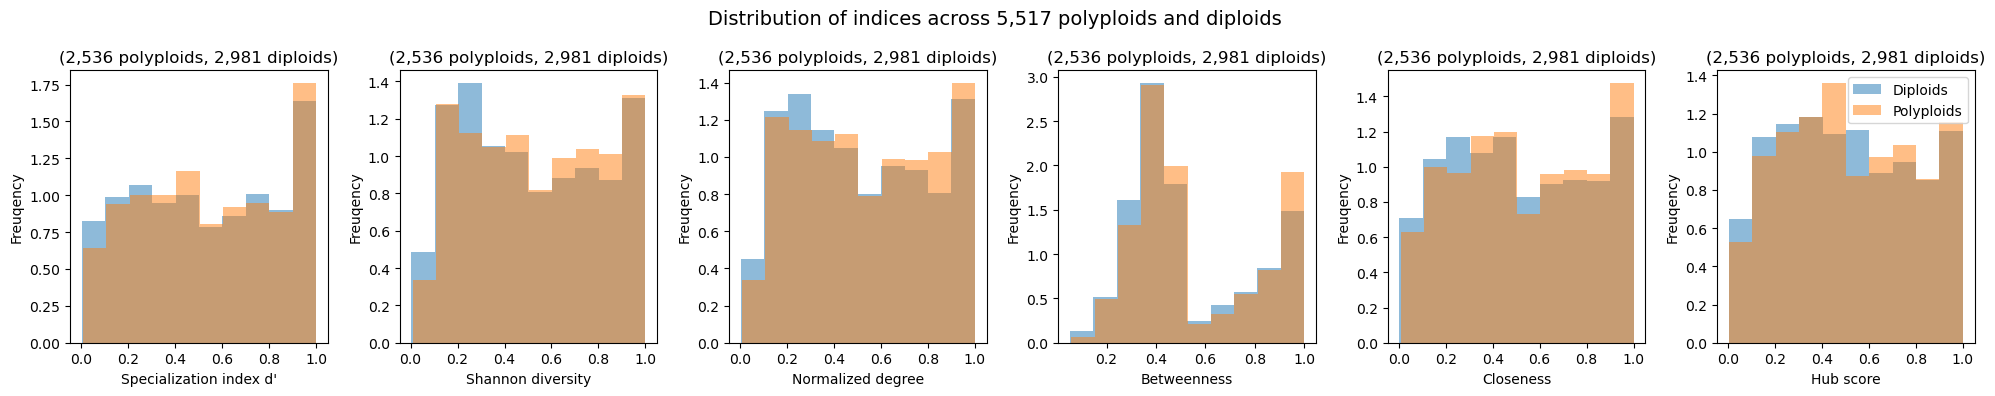

In [181]:
plot_hist_dist_across_var_cat(df=full_dataset, varname="", outpath="../../../data/figures/distribution_of_indices_baseline_full_dataset.jpeg")

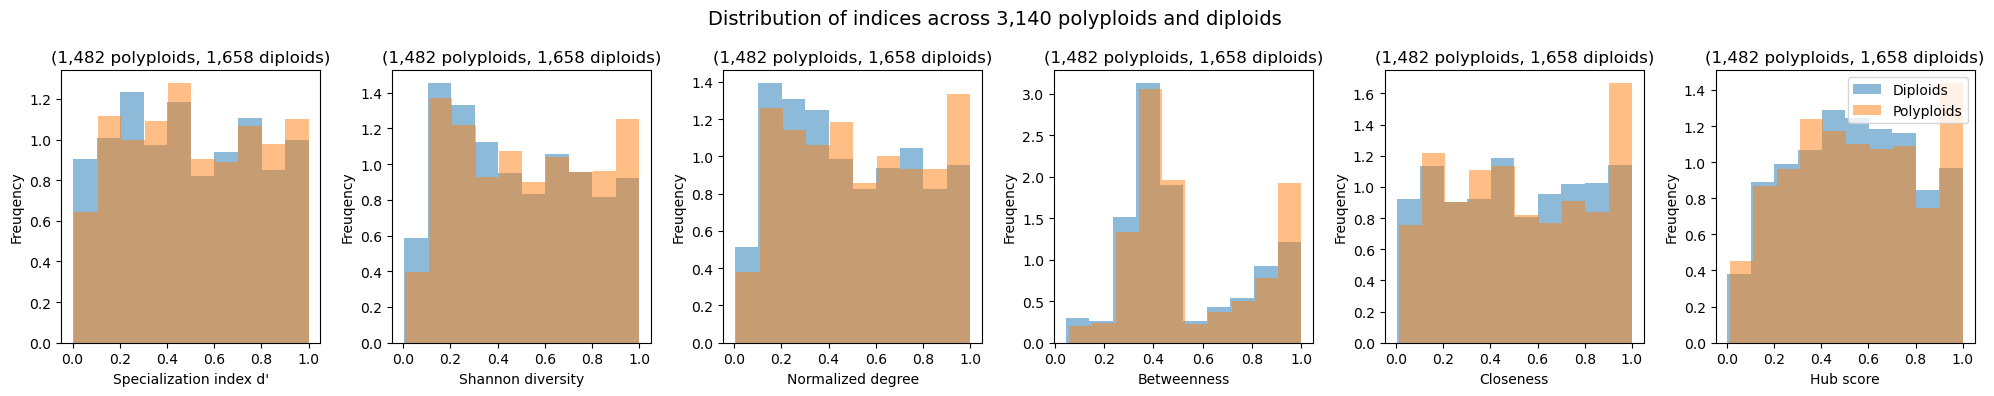

In [86]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="", outpath="../../../data/figures/distribution_of_indices_baseline_limited_dataset.jpeg")

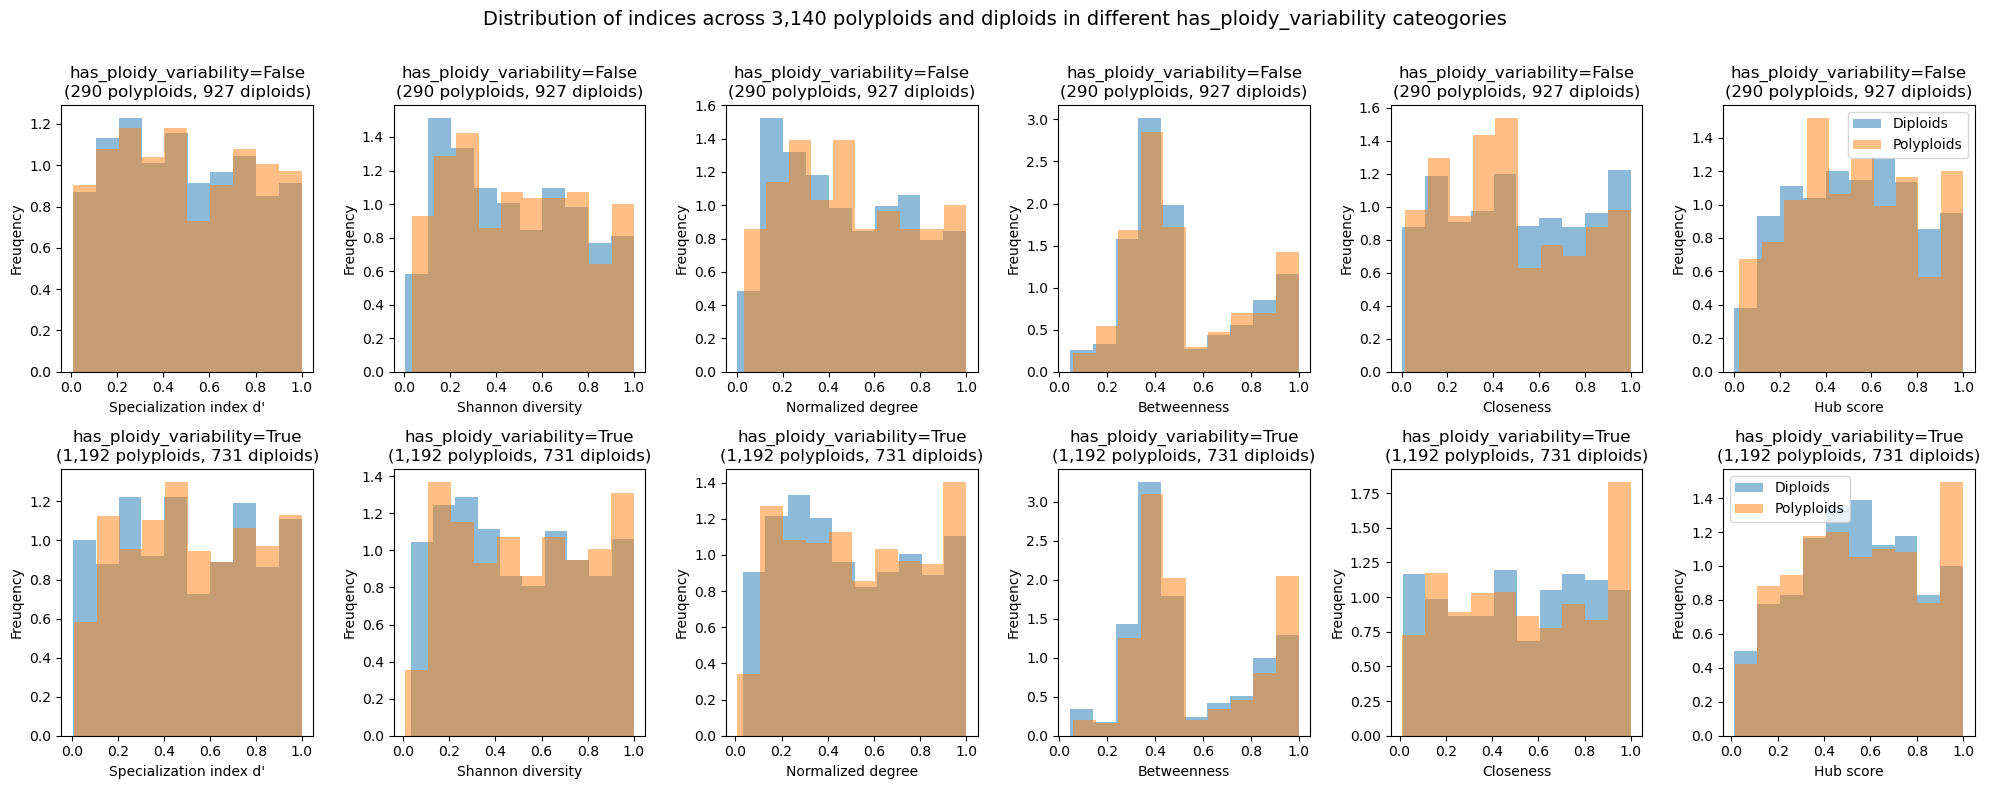

In [87]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="has_ploidy_variability", outpath="../../../data/figures/spec_indices_dif_ploidy_var.jpeg")

invalid literal for int() with base 10: 'woody'


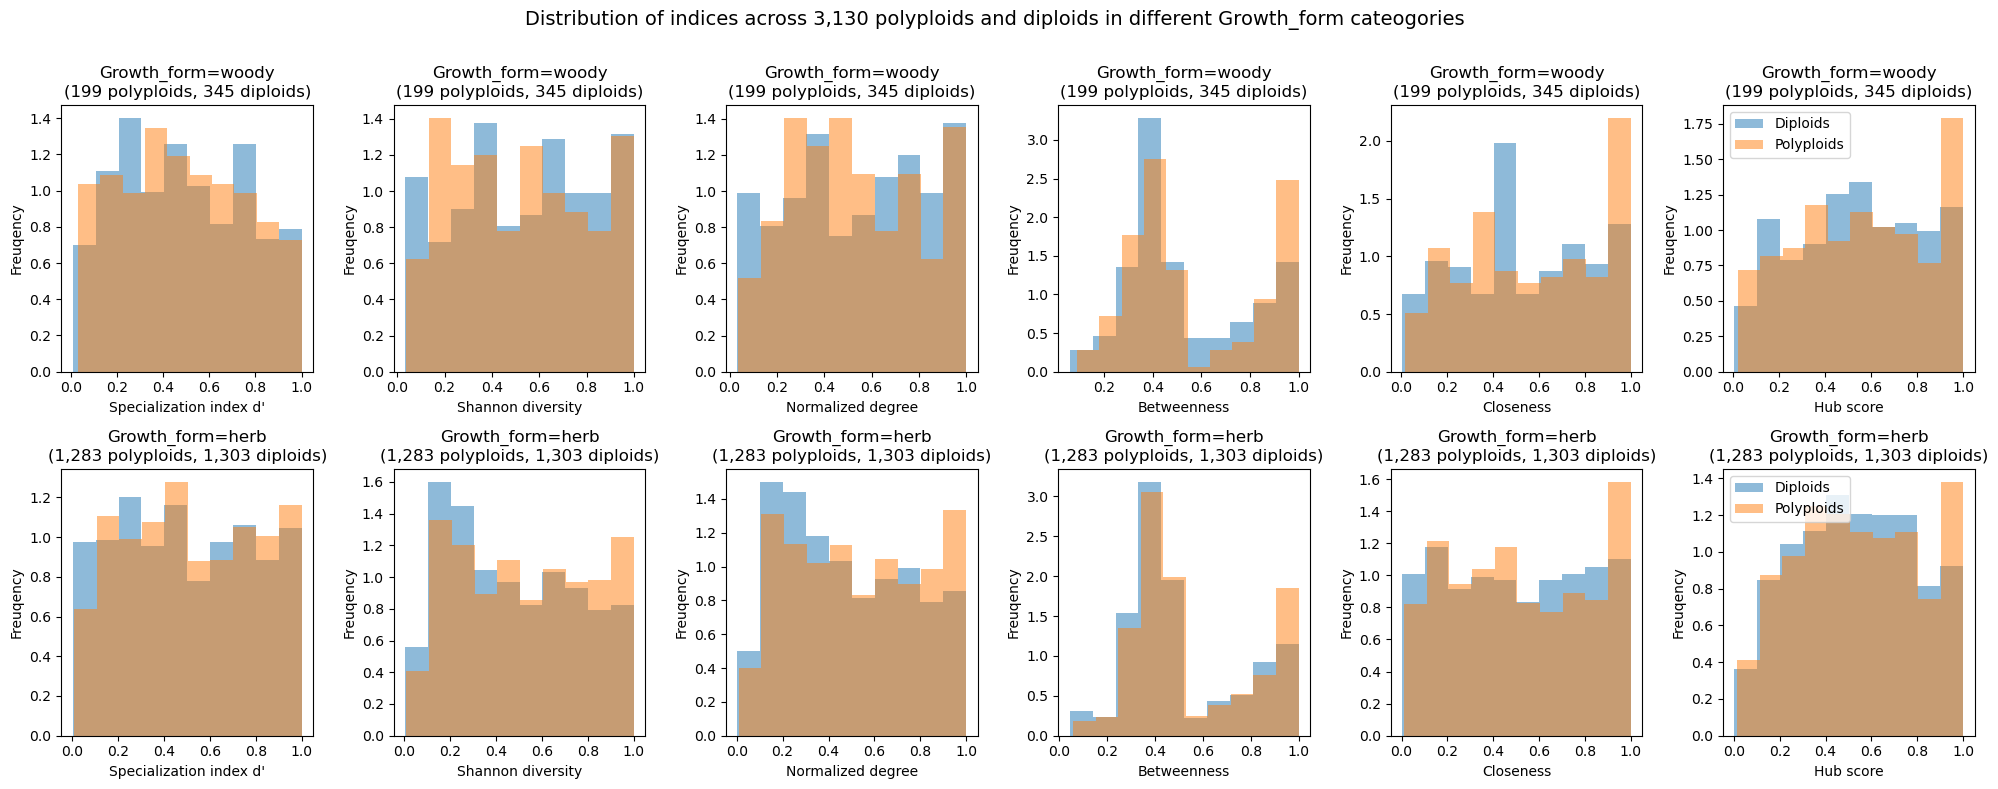

In [88]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="Growth_form", outpath="../../../data/figures/spec_indices_dif_gf.jpeg")

invalid literal for int() with base 10: 'perennial'


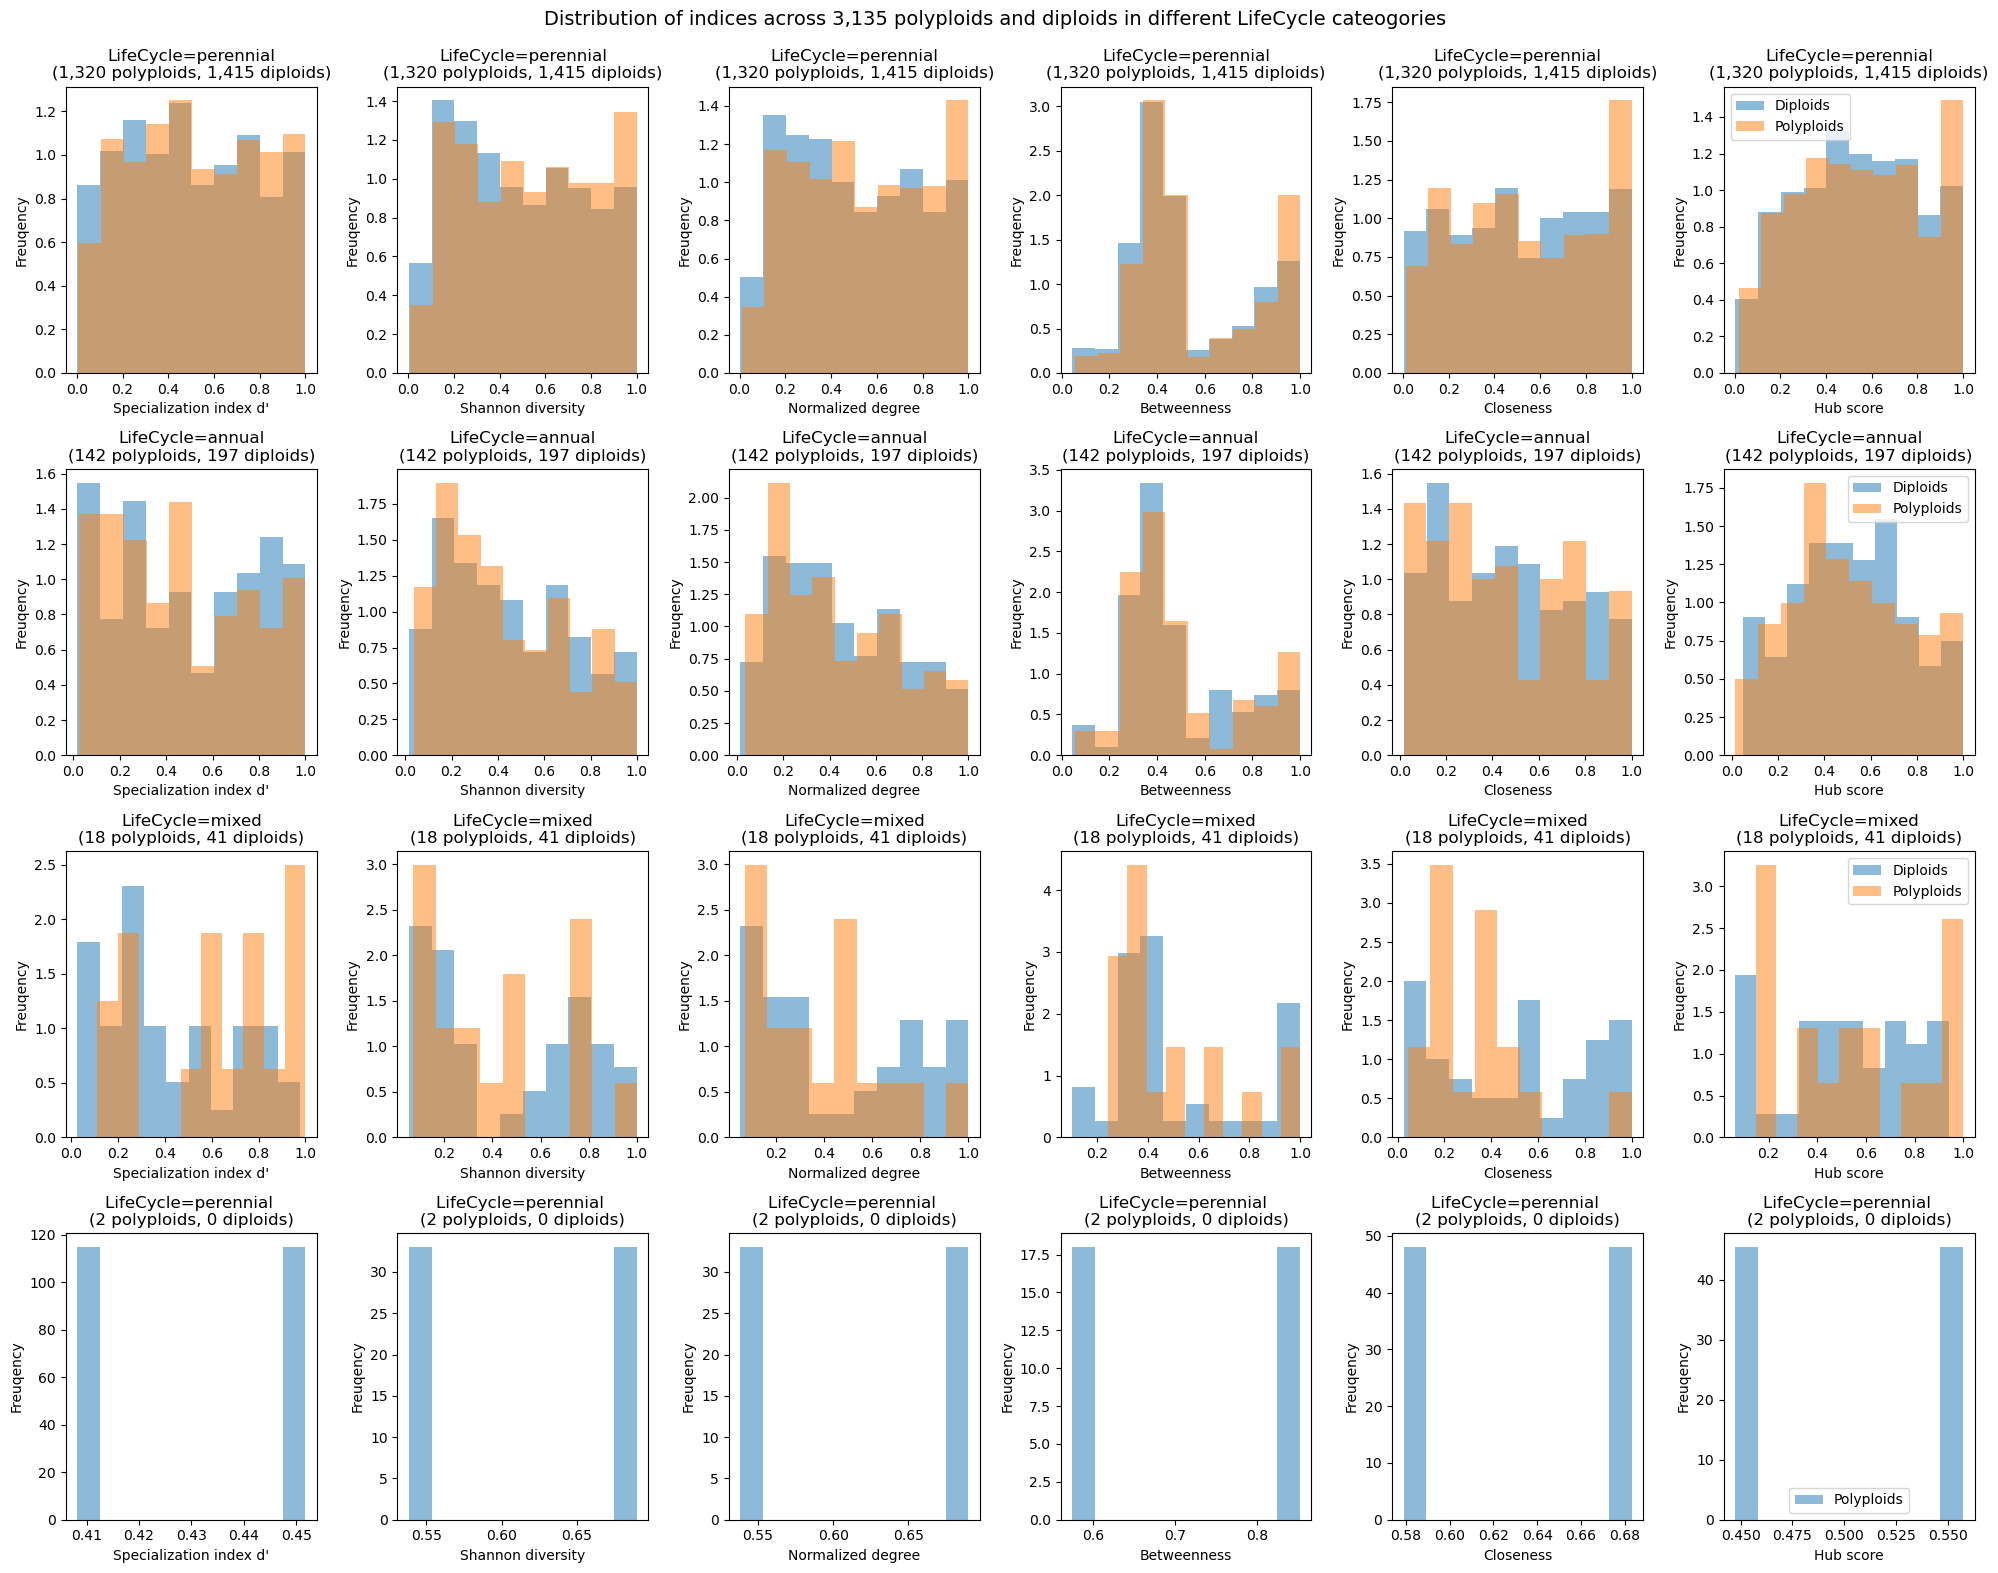

In [89]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="LifeCycle", outpath="../../../data/figures/spec_indices_dif_cl.jpeg")

invalid literal for int() with base 10: 'woody'


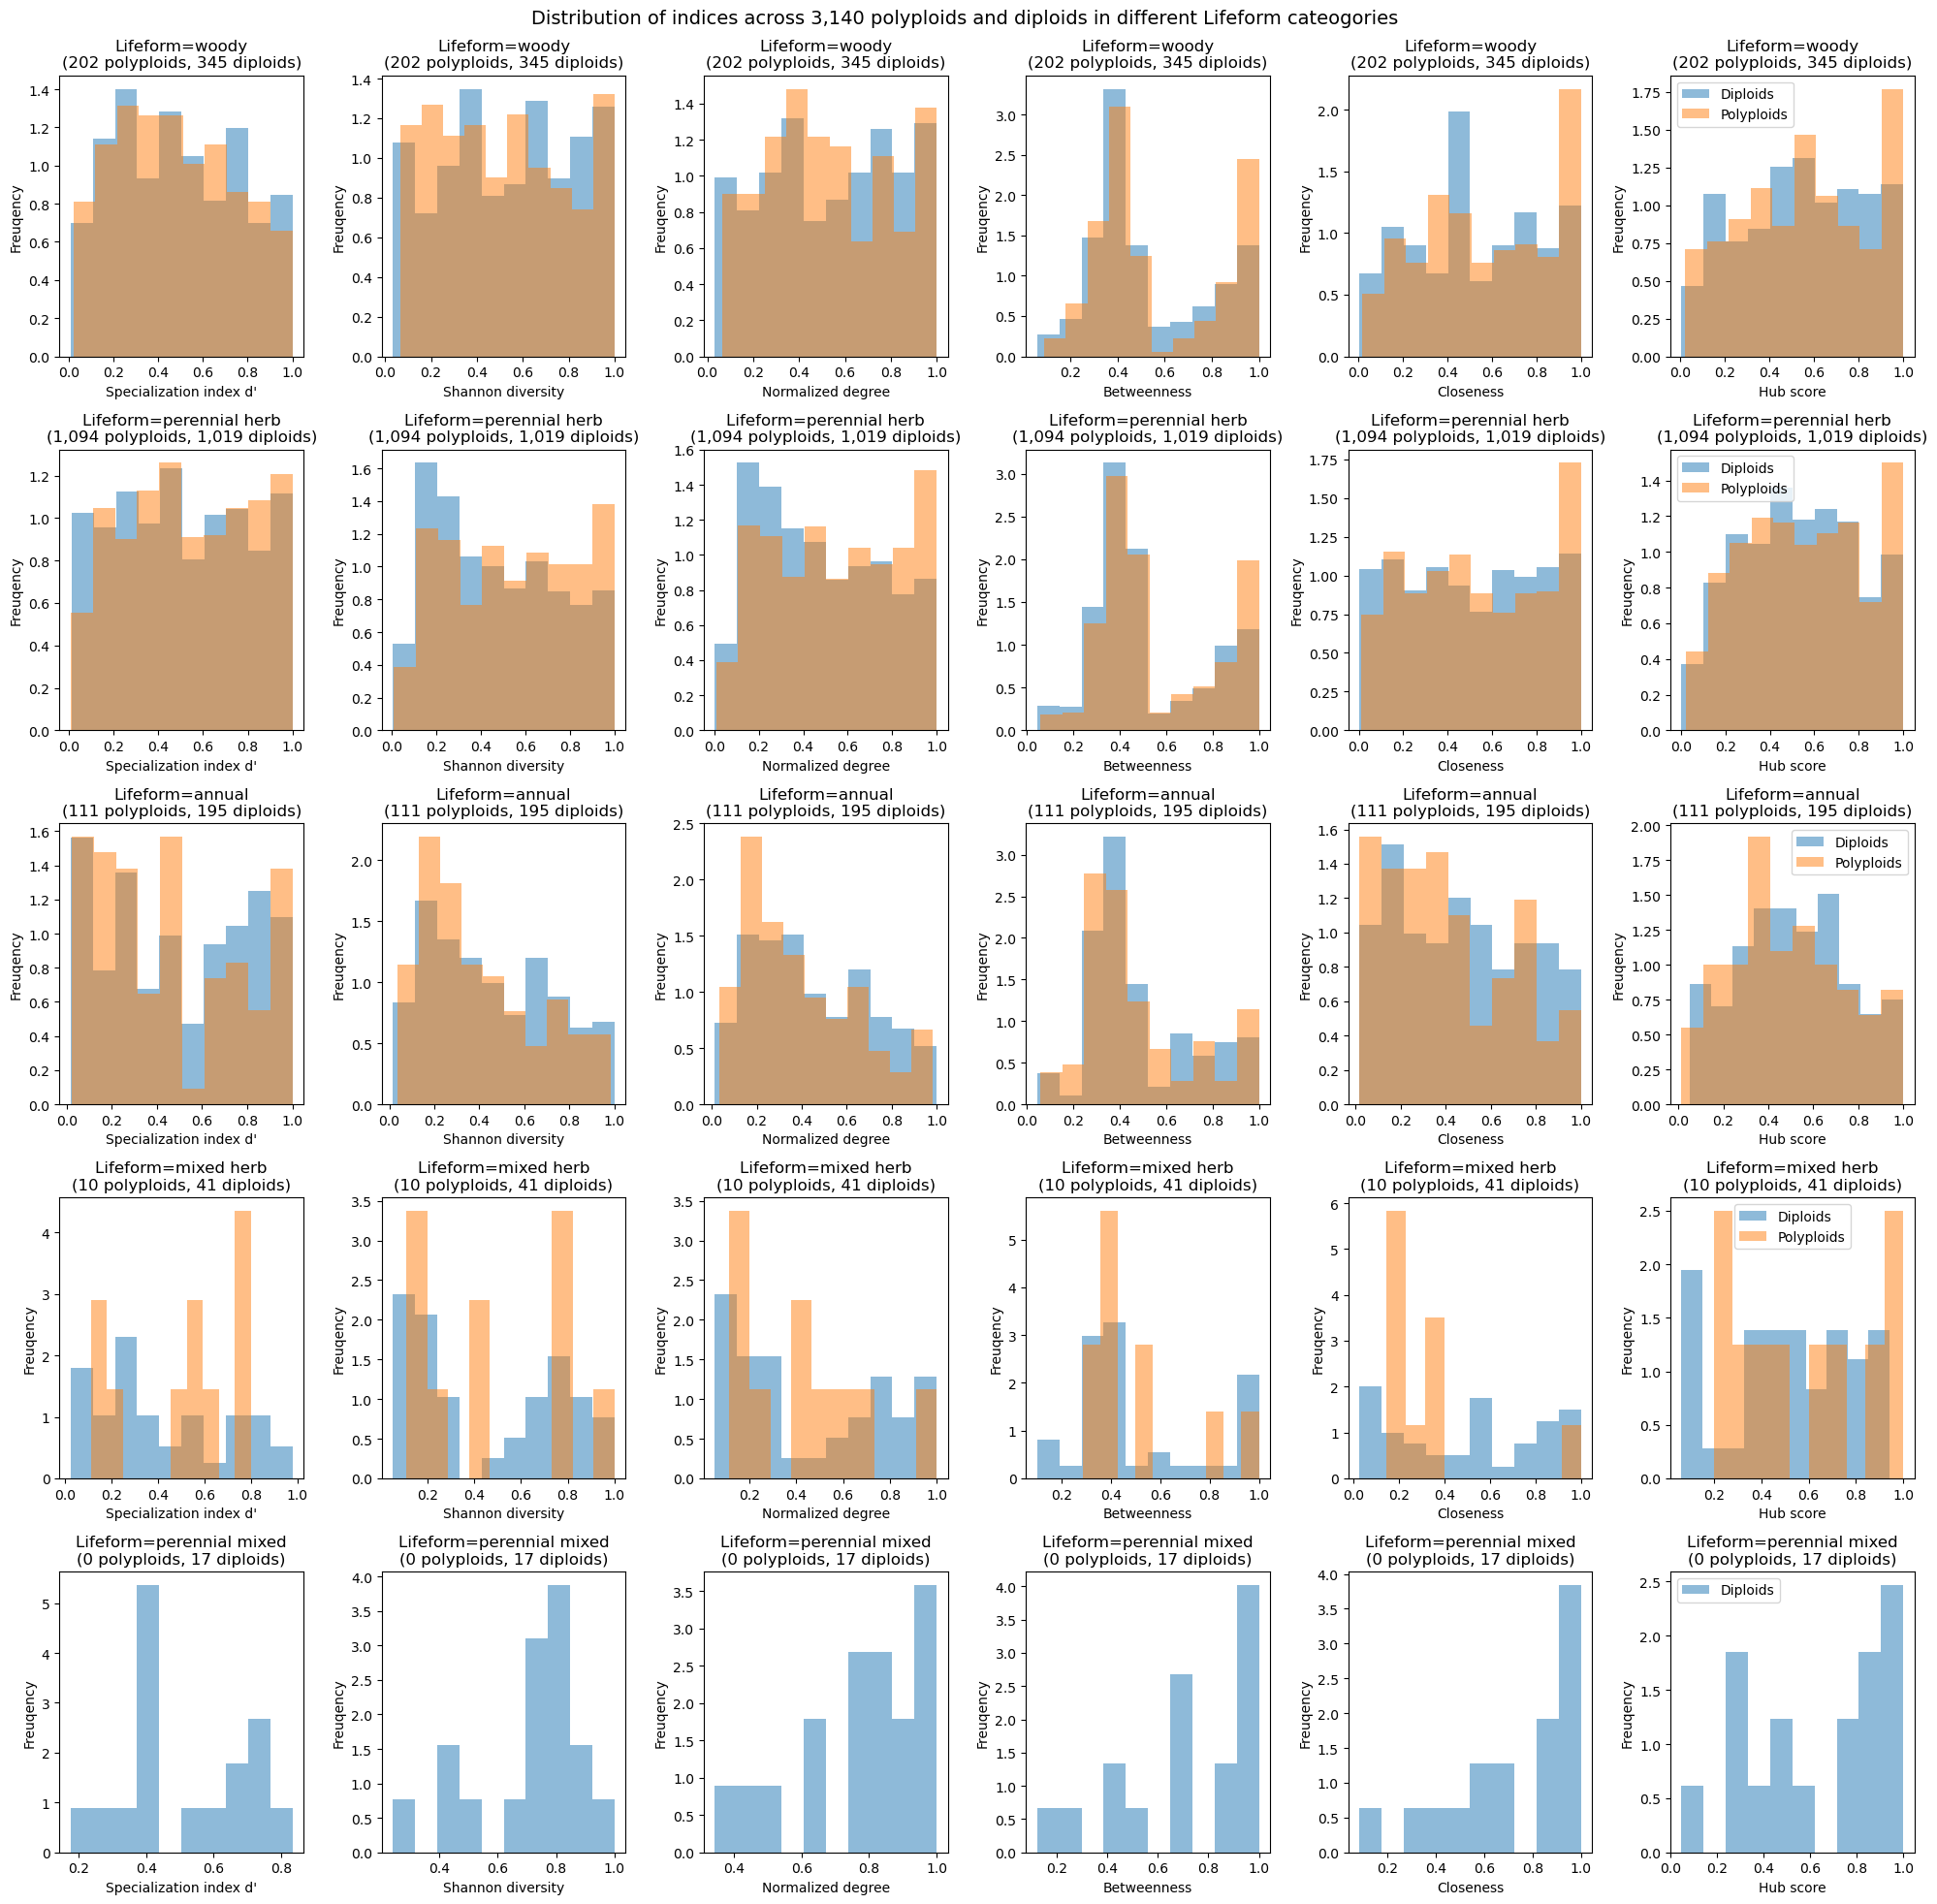

In [90]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="Lifeform", outpath="../../../data/figures/spec_indices_dif_lifeform.jpeg")

invalid literal for int() with base 10: 'unknown'


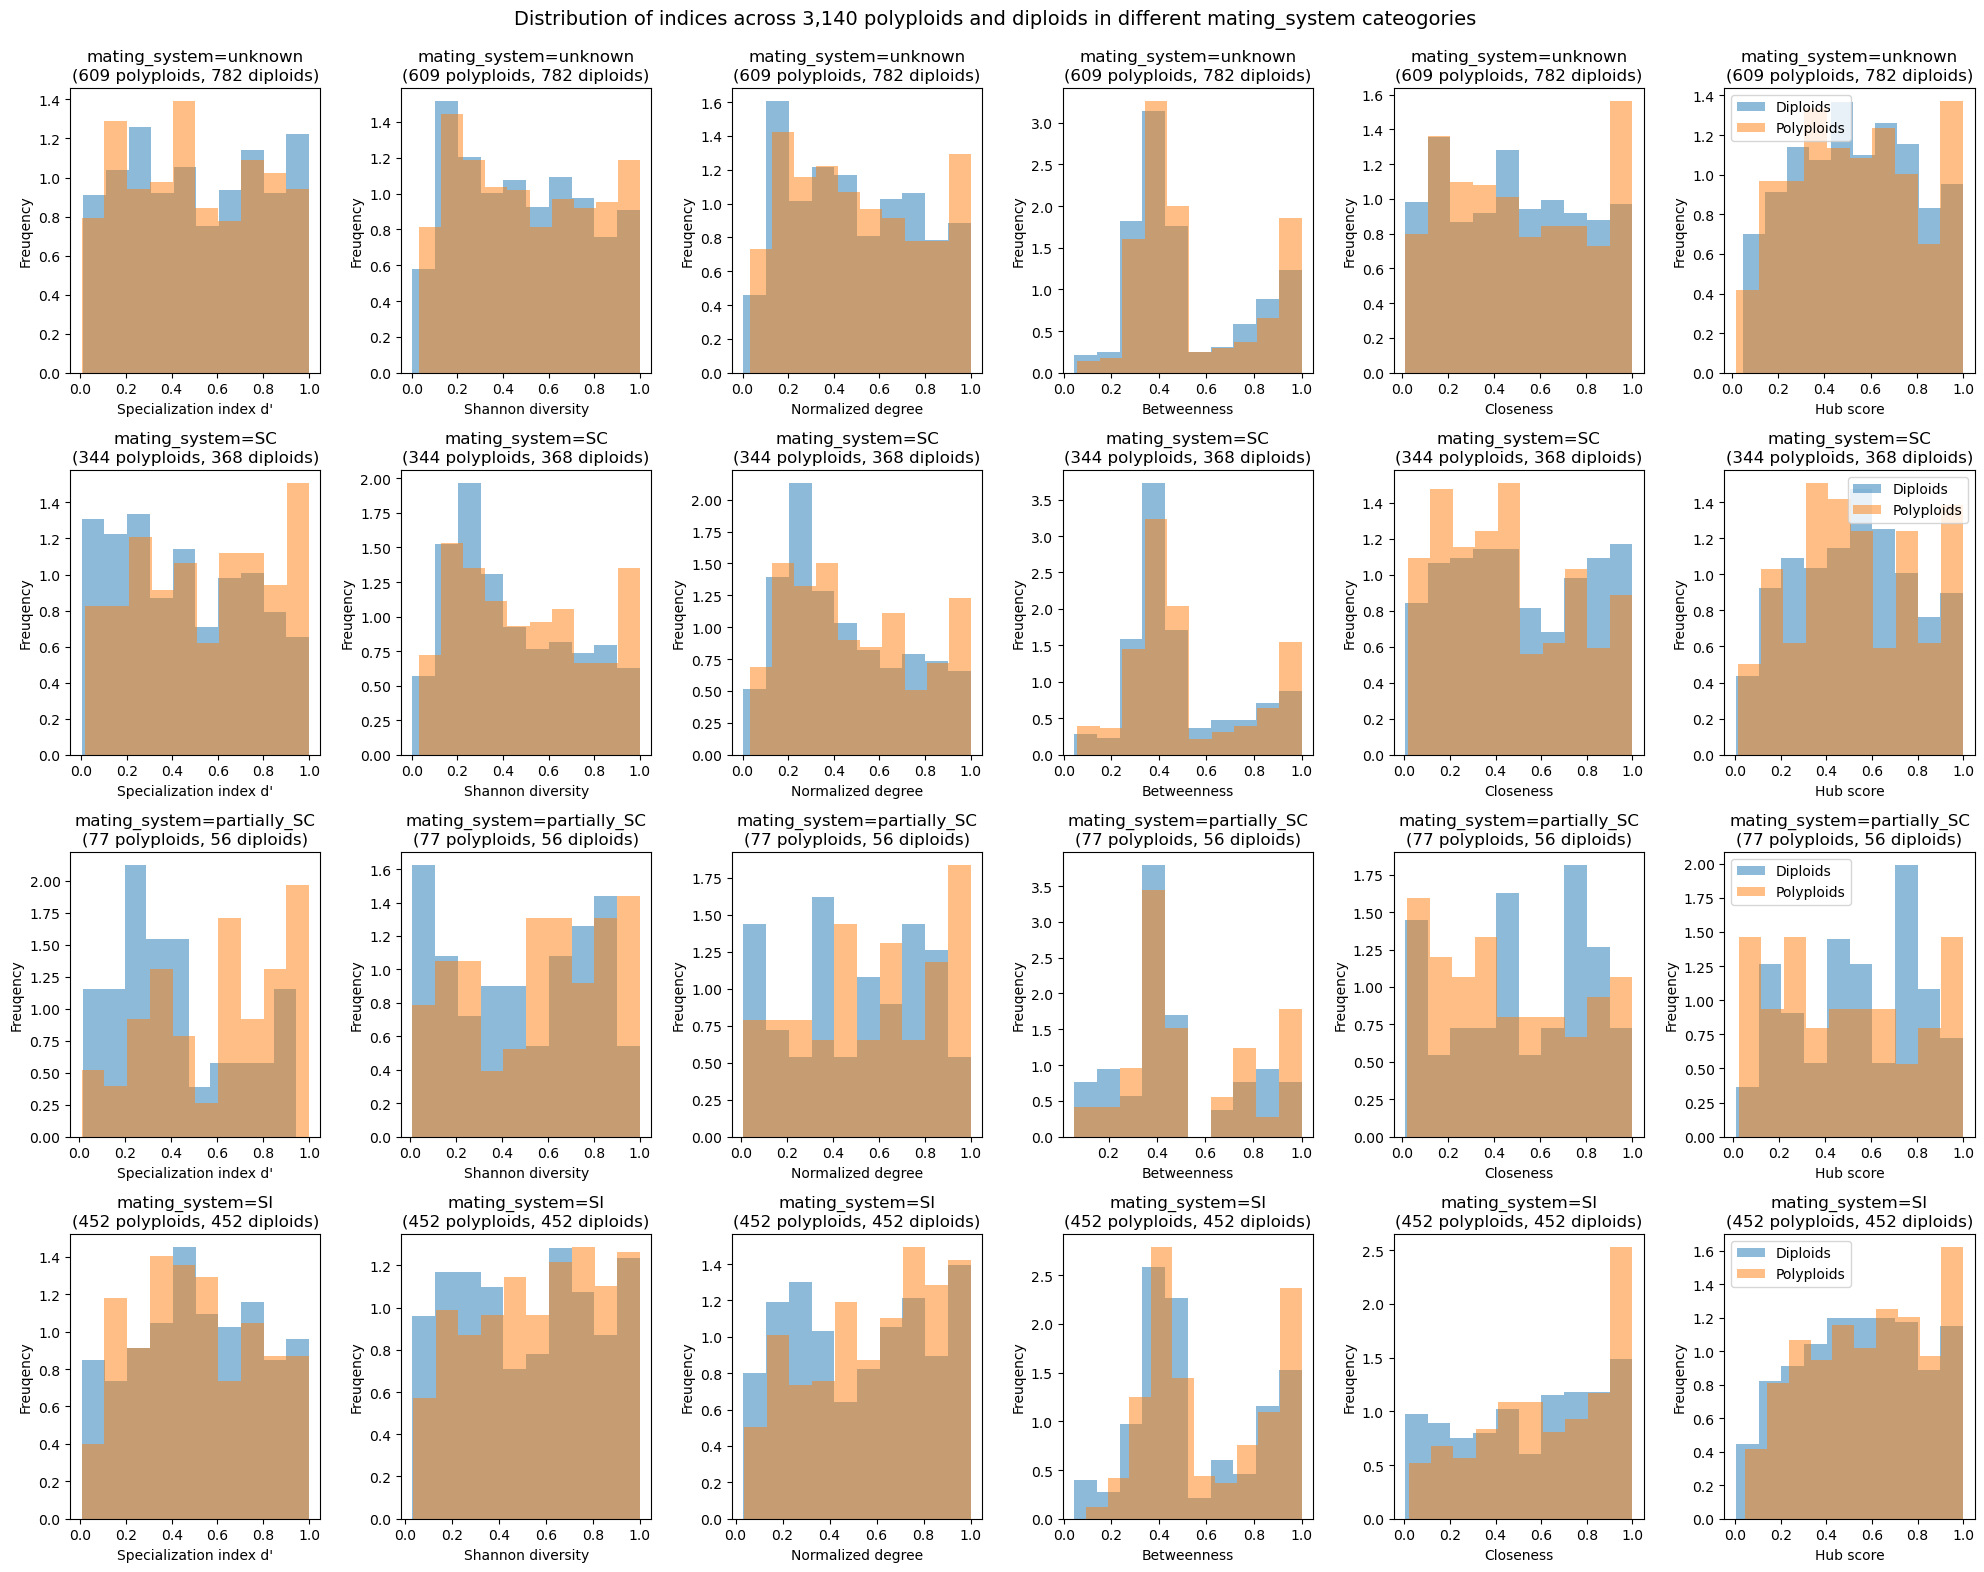

In [91]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="mating_system", outpath="../../../data/figures/spec_indices_dif_ms.jpeg")

# debug the inconsistencies between the full dataset and the limited dataset

In [116]:
full_dataset["in_limited"] = full_dataset.apply(lambda rec: pd.notna(rec.has_ploidy_variability) and
                                                pd.notna(rec.Lifeform) and
                                                pd.notna(rec.flw_color) and
                                                pd.notna(rec.flw_shape), axis=1)

In [117]:
debug = full_dataset.loc[full_dataset.in_limited == False]

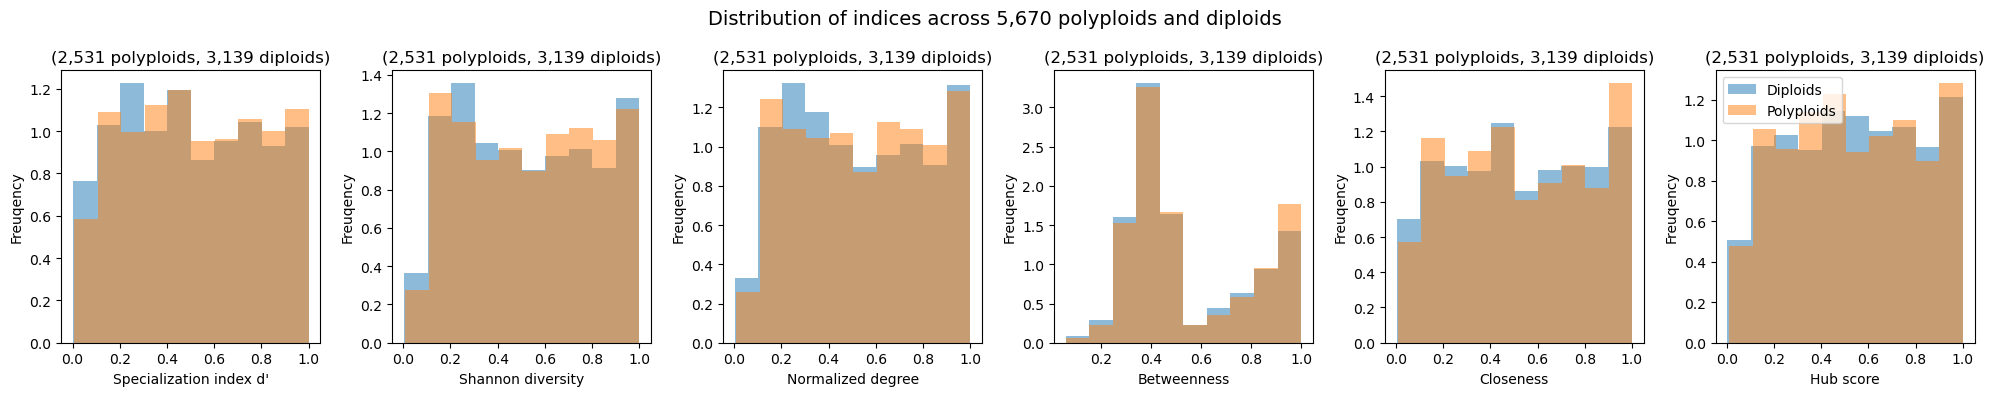

In [118]:
plot_hist_dist_across_var_cat(df=full_dataset, varname="", outpath="../../../data/figures/spec_across_full_data.jpeg")

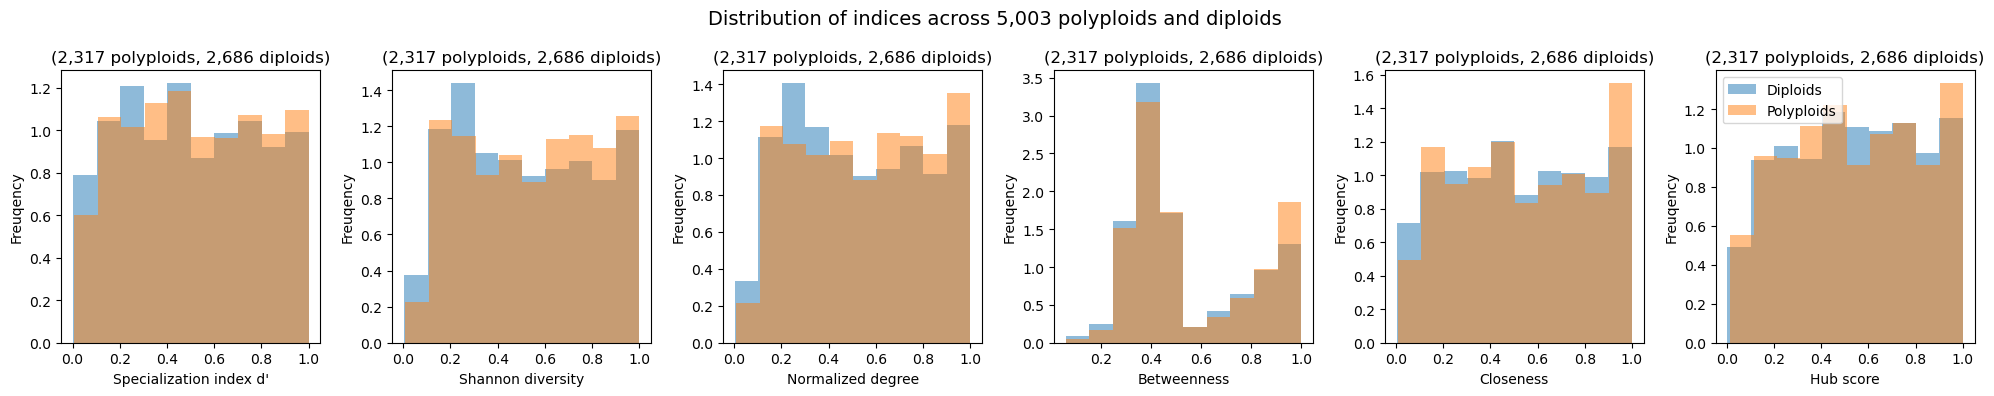

In [119]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="", outpath="../../../data/figures/spec_across_limited_data.jpeg")

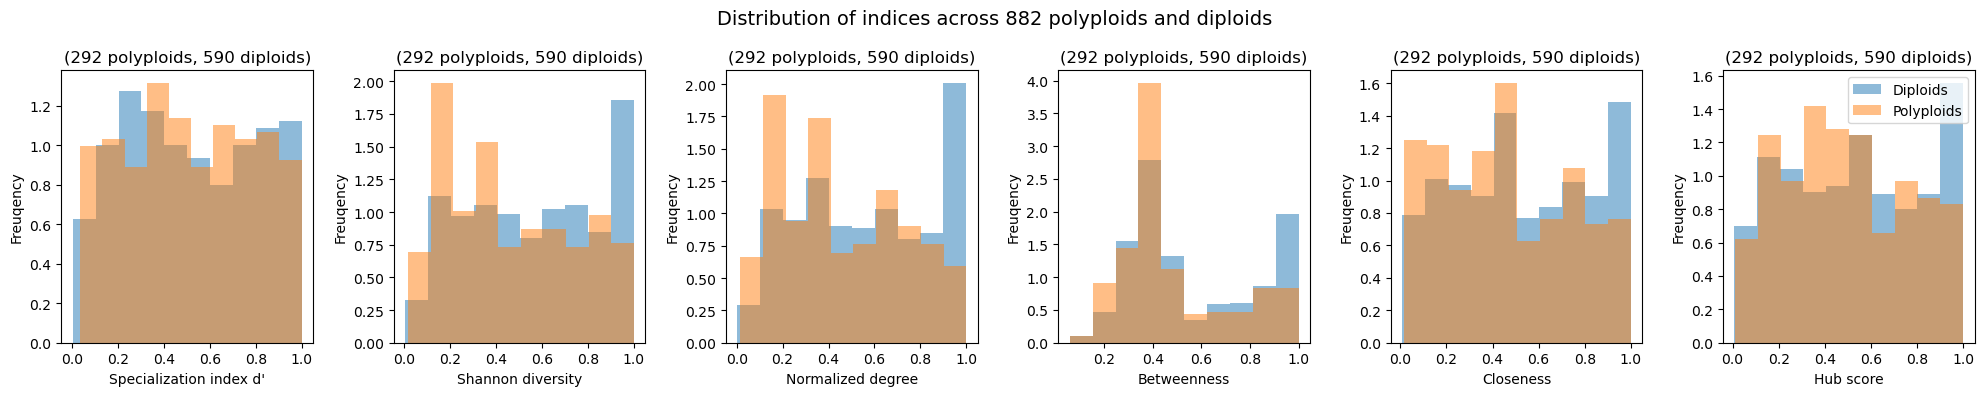

In [120]:
plot_hist_dist_across_var_cat(df=debug, varname="", outpath="../../../data/figures/spec_across_missing_data.jpeg")

In [121]:
full_dataset.loc[full_dataset['standardized_partner.diversity'] == 1].groupby("is_polyploid").Plant.count()

is_polyploid
Diploids      207
Polyploids    183
Name: Plant, dtype: int64

In [122]:
limited_dataset.loc[limited_dataset['standardized_partner.diversity'] == 1].groupby("is_polyploid").Plant.count()

is_polyploid
Diploids      158
Polyploids    178
Name: Plant, dtype: int64

In [123]:
limited_dataset.groupby("is_polyploid").Plant.count() / limited_dataset.shape[0]

is_polyploid
Diploids      0.536878
Polyploids    0.463122
Name: Plant, dtype: float64

In [124]:
full_dataset.groupby("is_polyploid").Plant.count() / full_dataset.shape[0]

is_polyploid
Diploids      0.553616
Polyploids    0.446384
Name: Plant, dtype: float64

# report available samples per meta feature

In [94]:
final_features_with_classification = pd.read_csv(processed_data_path)
cols = ['is_polyploid','ploidy_age','has_ploidy_variability',
        'mating_system','LifeCycle','Growth_form','Lifeform'] + [c for c in final_features_with_classification.columns if c.startswith("flw_")] + list(networks_metadata_rel_cols)
stats_report = final_features_with_classification[cols].notna().sum().reset_index().rename(columns={"index": "variable", 0:"n_samples"})

In [95]:
desc = {'is_polyploid': "binary ploidy level (0-diploid, 1-polyploid",
                                                     'ploidy_age': "inferred ploidy age from ploidb pipeline. for diplods with no age, age data was complemented based on ancient events inferred by the 1KP project",
                                                     'has_ploidy_variability': "flag indicating whether the taxon exhibits both diploid and polyploid individuals, inferred based on variablity in chromosome numbers exceeding 1.5*minimial reported number",
                                                     'mating_system': "type of mating sytem - sc (selfing compatible), si (selfing incompatible) or partially sc",
                                                     "flw_symmetry": "Symmetry of the corolla: zygomorphic; actinomorphic; asymmetric; no_corolla",
                                                     "flw_shape": "Whether the shape of the flower restricts pollinator accessibility to floral rewards or not: restrictive; unrestrictive",
                                                     "flw_color": "Visual spectra and predominant color of the corolla or color of the bracts or sepals when they are the predominant color for attraction (e.g., Bromeliads, Castilleja linariaefolia). When there is no predominant color (e.g. orchid flowers with yellow, purple, white, etc) define as multiple. Categories: White (cream), Purple, Blue, Green, Yellow, Orange, Red, Pink, Brown, Multiple",
                                                     "flw_len_mean": "Mean value of the linear length (mm) of the attractive unit of flower (e.g. corolla). Data calculated from 5 measured flowers (using digitized herbarium sheets) OR the sum between flw_len_min and flw_len_max divided by 2",
                                                     "num_of_flw_infl": "Number of flowers per inflorescence. Categories: single; multiple",
                                                     "LifeCycle": "the life cycle of the taxon: perennial, annual or mixed. In case of conflicting reports of a sole life cycle, the value is set as 'conflict'",
                                                     "Growth_form": "the growth form of the taxon: woody, herb or mixed. In case of conflicting reports of a sole life cycle, the value is set as 'conflict'",
                                                     "Lifeform": "the life form of the taxon: woody, annual or perrenial herb. In case of mixed life cycle, we define it as 'mixed_herb', and in case of mixed gowrg form, we define it as 'perennial_mixed'. in case of uclassified life form or growth form, we define it as 'unclassified_herb' or 'unclassified_perennial' respectively",
                                                     "Altitude": "the mean distance above sea level across the ecoregion area",
                                                     'Difference in glaciers': "The extent of de-glaciation since the LGM was estimated by comparing the present ice coverage of each ecoregion75 to that inferred for the LGM76. The result is expressed as the percentage of de-glaciation per ecoregion. When both past and present glaciation extents were missing, the ecoregion was discarded from this analysis. Therefore, this attribute was examined for the 207 ecoregions that had some ice coverage data but not across all ecoregions.",\
                                                     'Current glaciers': "estimated coverage of glaciers in the respective ecoregion, collected in 2019",
                                                     'LGM glaciers': "estimated coverage of glaciers in the respective ecoregion, 22,000 years ago", 
                                                     "species_richness": "regional species richness measured for the respective ecoregion obtained from Kier et al. (https://doi.org/10.1111/j.1365-2699.2005.01272.x)",
                                                     'Climate_PC1': "first PC in PCA on the 19 bioclimate variables. Explains 0.82 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Climate_PC2': "second PC in PCA on the 19 bioclimate variables. Explains 0.74 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Climate_PC3': "third PC in PCA on the 19 bioclimate variables. Explains 0.46 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'ChangeInClimate_PC1': "first PC in PCA on the 19 difference values between biolimate varaibles as measured in 2019 vs. 22,000 years ago. Explains 0.71 for the variablity. For loadings of varaibles see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'ChangeInClimate_PC2': "second PC in PCA on the 19 difference values between biolimate varaibles as measured in 2019 vs. 22,000 years ago. Explains 0.56 for the variablity. For loadings of varaibles see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'ChangeInClimate_PC3': "third PC in PCA on the 19 difference values between biolimate varaibles as measured in 2019 vs. 22,000 years ago. Explains 0.36 for the variablity. For loadings of varaibles see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'highest_pollinator_rank_index': "ordinal values of highest taxonomic ranks of pollinators documented in the network of the sample. 0 corresponds to the highest rank (tribe) and 9 to the lowest (species)",
                                                     'highest_pollinator_rank_name': "categorical values of highest taxonomic ranks of pollinators documented in the network of the sample. ranges from tribe (highest) to species (lowest)",
                                                     'Basal angiosperm %': "% of Basal angiosperm species recorded in the respective ecoregion, based on data from 2019",
                                                     'Asterids %': "% of Asterids species recorded in the respective ecoregion, based on data from 2019",
                                                     'Basal dicots %': "% of Basal dicots species recorded in the respective ecoregion, based on data from 2019",
                                                     'Basal monocots %':"% of Basal monocots species recorded in the respective ecoregion, based on data from 2019",
                                                     'Commelinids %': "% of Commelinids species recorded in the respective ecoregion, based on data from 2019",
                                                     'Rosids %': "% of Rosids species recorded in the respective ecoregion, based on data from 2019",
                                                     'Taxonomy_PC1': "first PC of PCA on the 6 taxonomic composition varaibles across ecoregions. explains 0.76 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Taxonomy_PC2': "second PC of PCA on the 6 taxonomic composition varaibles across ecoregions. explains 0.58 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Taxonomy_PC3': "third PC of PCA on the 6 taxonomic composition varaibles across ecoregions. explains 0.36 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Woody %': "% of woody species recorded in the respective ecoregion, based on data from 2019",
                                                     'Annual %': "% of annual species recorded in the respective ecoregion, based on data from 2019",
                                                     'Perennial herb %': "% of perennial herb species recorded in the respective ecoregion, based on data from 2019",
                                                     'Biome frequency': "first PC of PCA on the 3 lifeform composition varaibles across ecoregions. explains 1 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Lifeform_PC1': "first PC of PCA on the 3 lifeform composition varaibles across ecoregions. explains 1 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Lifeform_PC2': "second PC of PCA on the 3 lifeform composition varaibles across ecoregions. explains 0.99 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Lifeform_PC3': "third PC of PCA on the 3 lifeform composition varaibles across ecoregions. explains 0.73 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Polyploid percent': "% of polyploid species recorded in the respective ecoregion, based on data from 2019",
                                                     'Human footprint': "As a measure for anthropogenic disturbance of ecosystems (that is, the amount of land or sea necessary to support the consumption of local human activity, including population density, land transformation, accessibility and electrical power infrastructure), we used a data layer assembled by Sanderson et al.86." ,
                                                     'Elevation amplitude': "the difference between the 90th and 10th percentiles of altitude across the ercoregion area" ,
                                                     'Binomial PV': " the significance of the Binomial test comparing the ecoregions frequency to its surrounding biome",
                                                     'NPP': "net primary productivity, as estimated by Imhoff et al. (https://www.nature.com/articles/nature02619)",
                                                     'Phosphorus retention': "Phosphorus soil retention potential83 was extracted per ecoregion. This layer comprises 12 levels of phosphorus availability that were converted to a discrete numerical scale."}
stats_report["description"] = stats_report.variable.apply(lambda v: desc.get(v, np.nan))

In [96]:
stats_report.to_csv(f"variables_to_n_samples_{'un' if do_weighted==False else ''}weighted.csv")

# save species level phylogeny and trait data for phylogenetic signal visualization

In [382]:
df = pd.read_csv(processed_data_path)
df.Plant = df.Plant.str.replace(" ", "_")

In [383]:
cols = ["Plant", "Family", "Genus", "mating_system", "Growth_form", "LifeCycle", "Lifeform"] + [c for c in df.columns if "flw_" in c]
sp_spec_df = df[[c for c in cols if "network" not in c]].drop_duplicates().dropna(how="all")
print(f"# unique species = {sp_spec_df.shape[0]:,}")

# unique species = 1,672


In [384]:
allmb_tree = Tree(allmb_tree_path, format=1)
for l in allmb_tree.get_leaves():
    l.name = l.name.lower().replace(" ", "_")
sp_in_tree = set(sp_spec_df.Plant)&set(allmb_tree.get_leaf_names())
len(sp_in_tree)

1504

In [385]:
allmb_tree.prune(sp_in_tree, preserve_branch_length=True)
allmb_tree.write(outfile="../../../data/statistical_analysis/species_level/traits_tree.nwk", format=1)

In [386]:
species_metadata_3 = pd.read_excel(species_metadata_path_3, sheet_name="Data")
species_metadata_3.scientificName = species_metadata_3.scientificName.str.lower()
sp_to_fam = species_metadata_3.set_index("scientificName")["family"].to_dict()
sp_spec_df.loc[sp_spec_df.Family.isna(), "Family"] = sp_spec_df.Plant.apply(lambda n: sp_to_fam.get(n.replace("_", " "), np.nan))

/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [387]:
sp_spec_df.LifeCycle = sp_spec_df.LifeCycle.replace({"perennial": "perennial", "Annual":"annual", "annual\xa0": "annual", "perennial\xa0": "perennial"})
sp_spec_df = sp_spec_df.loc[sp_spec_df.Plant.isin(sp_in_tree)]

In [388]:
sp_class = pd.read_csv("../../../data/trees/species_family_classification.csv")
sp_class.Plant = sp_class.Plant.str.replace(" ", "_")
sp_to_fam = sp_class.set_index("Plant")["Family"].to_dict()

In [389]:
sp_spec_df.Family = sp_spec_df.apply(lambda rec: sp_to_fam.get(rec.Plant,np.nan) if pd.notna(sp_to_fam.get(rec.Plant,np.nan)) else rec.Family, axis=1).str.lower()

In [390]:
ast_members_by_me = sp_class.query("Family == 'asteraceae'").Plant.str.replace(" ", "_").tolist()
ast_members_by_spec = sp_spec_df.query("Family == 'asteraceae'").Plant.str.replace(" ", "_").tolist()
sp_spec_df.loc[sp_spec_df.Plant.isin(set(ast_members_by_me)-set(ast_members_by_spec)), "Family"] = "asteraceae"
ast_members_by_spec = sp_spec_df.query("Family == 'asteraceae'").Plant.str.replace(" ", "_").tolist()

In [391]:
sp_spec_df.dropna(subset=["Family"]).loc[sp_spec_df.Family.str.startswith('a', na=False)].groupby("Family").Plant.count()

Family
acanthaceae          11
actinidiaceae         2
alismataceae          3
alstroemeriaceae      4
amaranthaceae         8
amaryllidaceae       16
anacardiaceae         1
apiaceae             34
apocynaceae          12
aquifoliaceae         3
araceae               2
araliaceae            2
argophyllaceae        1
aristolochiaceae      1
asparagaceae         15
asphodelaceae         1
asteraceae          281
Name: Plant, dtype: int64

In [392]:
allmb_tree.check_monophyly(values=ast_members_by_spec, target_attr="name", ignore_missing=True)

(True, 'monophyletic', set())

In [393]:
lca = allmb_tree.get_common_ancestor(list(ast_members_by_spec))
print(f"# leaves under astereceae lca = {len(lca.get_leaves())}")

# leaves under astereceae lca = 281


In [394]:
sp_spec_df.to_csv("../../../data/statistical_analysis/species_level/traits_data_for_phylo_analysis.csv")
allmb_tree.write(outfile="../../../data/statistical_analysis/species_level/traits_tree.csv")

# save the plant traits db

In [ ]:
df = pd.read_csv(processed_data_path).drop_duplicates("Plant")
df = df[['original_name', 'resolved_name', 'resolved_species',
        'is_polyploid', 'ploidy_age', 'has_ploidy_variability', 
       'flw_len_max_AST_floret_level', 'flw_shape_AST_head_level',
       'n_flw_infl_AST_head_level', 'flw_len_mean_AST_head_level',
       'n_flw_infl_AST_floret_level', 'flw_len_min_AST_floret_level',
       'flw_len_min_AST_head_level', 'flw_symmetry_AST_floret_level',
       'flw_len_mean_AST_floret_level', 'flw_shape_AST_floret_level',
       'flw_color', 'flw_symmetry_AST_head_level',
       'flw_len_max_AST_head_level', 'mating_system',
       'Family', 'Genus', 'LifeCycle', 'Growth_form', 'Lifeform']]
df.to_csv("../../../data/plant_traits_db.csv", index=False)